# Natality file: Statistical Data Analysis #

Add intro


## Load packages, dataset, and create functions ##

In [1]:
# Load packages
import numpy as np
import scipy.stats as st
import pandas as pd
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
import datetime


In [2]:
# ECDF function
def ecdf(data):
    """Compute ECDF for a one-dimensional array of measurements."""
    # Number of data points: n
    n = len(data)
    # x-data for the ECDF: x
    x = np.sort(data)
    # y-data for the ECDF: y
    y = np.arange(1, n+1) / n
    return x, y
    

In [3]:
def ecdf2(data):
    # create a sorted series of unique data
    cdfx = np.sort(data.unique())
    # x-data for the ECDF: evenly spaced sequence of the uniques
    x_values = np.linspace(start=min(cdfx), stop=max(cdfx), num=len(cdfx))
    # size of the x_values
    size_data = data.size
    # y-data for the ECDF:
    y_values = []
    for i in x_values:
      # all the values in raw data less than the ith value in x_values
        temp = data[data <= i]
        # fraction of that value with respect to the size of the x_values
        value = temp.size / size_data
        # pushing the value in the y_values
        y_values.append(value)
    # return both x and y values    
    return x_values, y_values

In [4]:
# Change figure size
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

In [5]:
# Load data
df_raw = pd.read_csv('data/df_raw_nona_42.csv', index_col=0)
df_raw['premature'] = 0
df_raw.head()

/Users/berenice/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (9,42) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/berenice/anaconda3/lib/python3.7/site-packages/numpy/lib/arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,birth_month,birth_time,birth_weekday,birth_place,mother_age,mother_nativity,mother_race,mother_hispanic,paternity_acknowledged,mother_education,...,payment,plural_birth,sex,gestation_week,obstetric_estimate,birth_weight,no_abnormal_condition,no_congenital_anomalies,breastfed,premature
1,1,1227.0,2,1.0,30,1,1,0.0,X,6.0,...,2.0,1,M,38.0,40.0,3657.0,1.0,1.0,Y,0
2,1,1704.0,2,1.0,35,1,3,0.0,Y,NaN,...,1.0,1,F,39.0,39.0,3242.0,0.0,1.0,Y,0
3,1,336.0,2,1.0,28,1,1,0.0,X,6.0,...,4.0,1,M,37.0,36.0,3470.0,1.0,1.0,Y,0
4,1,938.0,2,1.0,23,1,3,0.0,Y,2.0,...,1.0,1,F,31.0,39.0,3140.0,1.0,1.0,N,0
5,1,830.0,3,1.0,37,1,1,0.0,X,4.0,...,1.0,1,M,37.0,37.0,2125.0,0.0,1.0,Y,0


In [7]:
df_raw.premature = df_raw.obstetric_estimate.between(0, 36)
df_raw.head()

,birth_month,birth_time,birth_weekday,birth_place,mother_age,mother_nativity,mother_race,mother_hispanic,paternity_acknowledged,mother_education,...,payment,plural_birth,sex,gestation_week,obstetric_estimate,birth_weight,no_abnormal_condition,no_congenital_anomalies,breastfed,premature
1,1,1227.0,2,1.0,30,1,1,0.0,X,6.0,...,2.0,1,M,38.0,40.0,3657.0,1.0,1.0,Y,False
2,1,1704.0,2,1.0,35,1,3,0.0,Y,NaN,...,1.0,1,F,39.0,39.0,3242.0,0.0,1.0,Y,False
3,1,336.0,2,1.0,28,1,1,0.0,X,6.0,...,4.0,1,M,37.0,36.0,3470.0,1.0,1.0,Y,True
4,1,938.0,2,1.0,23,1,3,0.0,Y,2.0,...,1.0,1,F,31.0,39.0,3140.0,1.0,1.0,N,False
5,1,830.0,3,1.0,37,1,1,0.0,X,4.0,...,1.0,1,M,37.0,37.0,2125.0,0.0,1.0,Y,False


In [8]:
# Count premature births 
df_prop = df_raw.groupby('premature').birth_month.count()
print('Proportion of premature births: ', df_prop[1]/(df_prop[0]+df_prop[1]))

Proportion of premature births:  0.10007854723908823


In [9]:
# Filter out non-spontaneous births
df_spon = df_raw[(df_raw.labor_trial == 'Y')  | (df_raw.delivery_method == 1)]
df_spon = df_spon[(df_raw.induction == 'N')]

/Users/berenice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
df = df_spon
# Count premature births 
df_prop = df.groupby('premature').birth_month.count()
print('Proportion of premature births: ', df_prop[1]/(df_prop[0]+df_prop[1]))

Proportion of premature births:  0.08319231367837733


## Confirm trends seen in EDA are backed up by statistics ##

### Physiological factors ###

1. Effect of height and weight of the mother

Visual EDA identified a slight linear relation between the height of the mother and the delivery week, as well as an optimal range for her weight. The BMI, which is a combination of height and weight, can be used alternatively to capture this optimum.

In [10]:
df.mother_height = df.mother_height.fillna(64) 
df.obstetric_estimate = df.obstetric_estimate.fillna(39)
pear_height= st.pearsonr(df.mother_height, df.obstetric_estimate)
print('The correlation between height of the mother and delivery week is not very strong with a Pearson coefficient of ', round(pear_height[0], 4))

The correlation between height of the mother and delivery week is not very strong with a Pearson coefficient of  0.0463


We then looked at the proportion of premature births by height of the mother

In [11]:
# Calculate the proportion of premature babies at each height
height = df.groupby(["mother_height", "premature"]).obstetric_estimate.count()
height = height.unstack("premature")
df_height = height.reset_index().fillna(0)

p_true = np.divide(df_height.iloc[:,1], (df_height.iloc[:,1]+df_height.iloc[:,2]))
df_height.insert(1, 'prop_true', p_true)
df_height.insert(1, 'prop_false', 1- p_true)

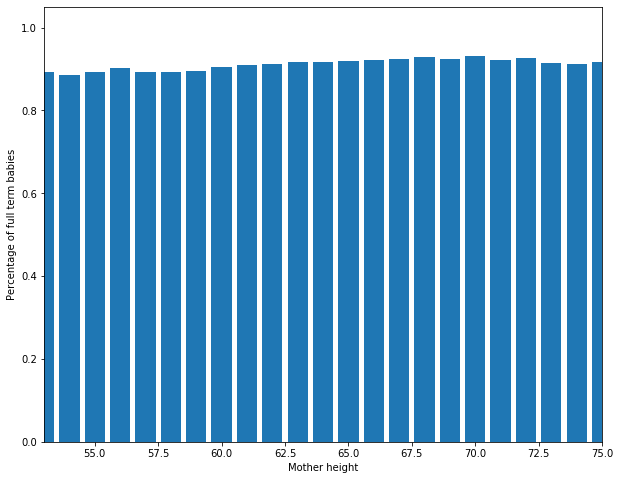

In [12]:
# Barplot of proportion of full term babies per height of the mother
_ = plt.bar(df_height.mother_height, df_height.prop_true)
_ = plt.xlim(53, 75)
_ = plt.xlabel("Mother height")
_ = plt.ylabel("Percentage of full term babies")

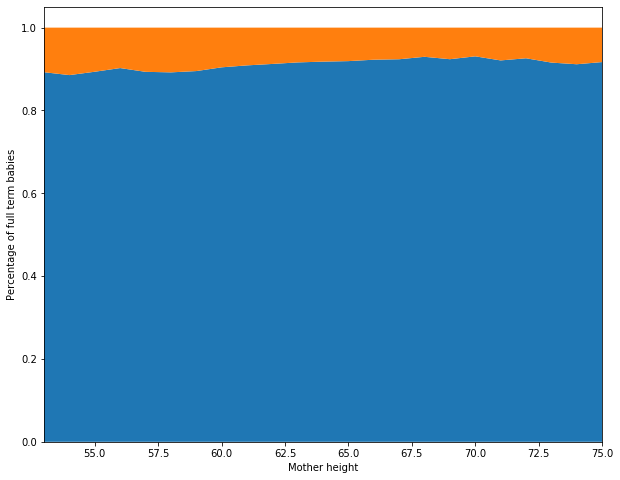

In [13]:
# Histogram of proportion of premature per height
_ = plt.stackplot(df_height.mother_height, [df_height.prop_true, df_height.prop_false], labels=['Full Term', 'Preterm'])
_ = plt.xlim(53, 75)
_ = plt.xlabel("Mother height")
_ = plt.ylabel("Percentage of full term babies")

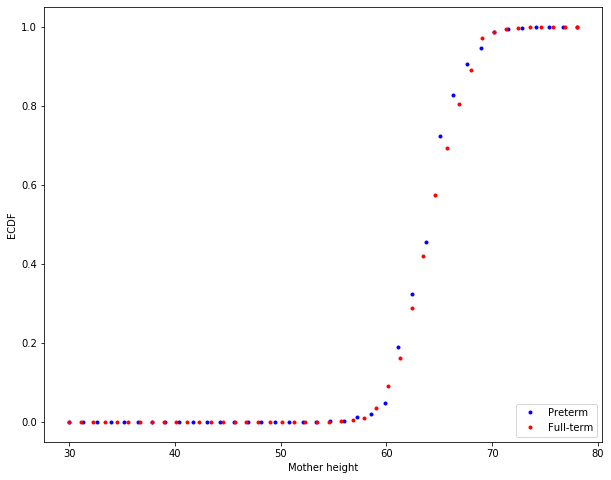

In [14]:
# ECDF mother height of premature vs full-term
x_prem, y_prem = ecdf2(df[df.premature == True].mother_height)
x_ft, y_ft = ecdf2(df[df.premature == False].mother_height)

plt.plot(x_prem, y_prem, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ft, y_ft, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Mother height')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

By looking at the barplot, it seems that the risk for premature birth decreases slightly with the height of the mother. The ECDF indicates a slighlty different distribution for the two population. 

We will use a one-way ANOVA to comfirm this (null hypothesis: the mean of mothers height is the same for preterm and full term birth). 

In [15]:
# ANOVA: mother height of premature vs full-term
full_t = df[df.premature == False].mother_height.dropna() 
premat = df[df.premature == True].mother_height.dropna()
mean_full_t = np.mean(full_t)
mean_premat = np.mean(premat)
print('Mean mother height for premature babies :', round(mean_premat, 2))
print('Mean mother height for full-term babies :', round(mean_full_t, 2))

ANOVA_height = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on height of the mother between full-term and preterm babies is', round(ANOVA_height[0], 2))
print('The p-value for the one-way ANOVA on height of the mother between full-term and preterm babies is', round(ANOVA_height[1], 4))

Mean mother height for premature babies : 63.87
Mean mother height for full-term babies : 64.12
The F-value for the one-way ANOVA on height of the mother between full-term and preterm babies is 1192.27
The p-value for the one-way ANOVA on height of the mother between full-term and preterm babies is 0.0


The p-value indicates that we can reject the null hypothesis and that the difference between the heights of mothers of preterm and full term babies are indeed different.

We then move to the weight gain and use the same approach.

In [16]:
df_weight = df[['prepregnancy_weight', 'obstetric_estimate']].dropna()

pear_weight= st.pearsonr(df_weight.prepregnancy_weight, df_weight.obstetric_estimate)
print('The correlation between prepregnancy weight of the mother and delivery week is not very strong with a Pearson coefficient of ', round(pear_weight[0], 4))

The correlation between weight gain of the mother and delivery week is not very strong with a Pearson coefficient of  -0.0337


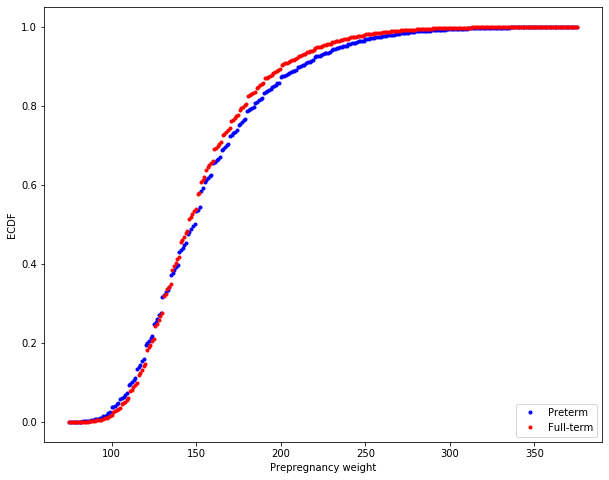

In [17]:
# ECDF weight gain of premature vs full-term
x_prem, y_prem = ecdf2(df[df.premature == True].prepregnancy_weight)
x_ft, y_ft = ecdf2(df[df.premature == False].prepregnancy_weight)

plt.plot(x_prem, y_prem, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ft, y_ft, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Prepregnancy weight')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

In [18]:
# ANOVA: mother prepregnancy weight of premature vs full-term
full_t = df[df.premature == False].prepregnancy_weight.dropna() 
premat = df[df.premature == True].prepregnancy_weight.dropna()
mean_full_t = np.mean(full_t)
mean_premat = np.mean(premat)
print('Mean prepregnancy weight for premature babies :', round(mean_premat, 2))
print('Mean prepregnancy weight  for full-term babies :', round(mean_full_t, 2))

ANOVA_weight = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on prepregnancy weight of the mother between full-term and preterm babies is', round(ANOVA_weight[0], 2))
print('The p-value for the one-way ANOVA on prepregnancy weight  of the mother between full-term and preterm babies is', round(ANOVA_weight[1], 4))

Mean prepregnancy weight for premature babies : 155.66
Mean prepregnancy weight  for full-term babies : 152.18
The F-value for the one-way ANOVA on prepregnancy weight of the mother between full-term and preterm babies is 1304.24
The p-value for the one-way ANOVA on prepregnancy weight  of the mother between full-term and preterm babies is 0.0


In [16]:
df.insert(23, 'weight_gain', df.delivery_weight - df.prepregnancy_weight)
mean_gain = np.mean(df.weight_gain)
df.weight_gain = df.weight_gain.fillna(mean_gain) 
pear_gain= st.pearsonr(df.weight_gain, df.obstetric_estimate)
print('The correlation between weight gain of the mother and delivery week is not very strong with a Pearson coefficient of ', round(pear_gain[0], 4))

The correlation between weight gain of the mother and delivery week is not very strong with a Pearson coefficient of  0.1272


In [17]:
# Calculate the proportion of premature babies for each weight gain
df_gain = df[(df.weight_gain >= -40.0) & (df.weight_gain <= 120.0)] #eliminate bins with less than 1000 observations
df_gain = df_gain.groupby(['weight_gain', "premature"]).obstetric_estimate.count()
df_gain = df_gain.unstack("premature")
df_gain = df_gain.reset_index().fillna(0)

groups = df_gain.groupby(pd.cut(df_gain.weight_gain, 16)).agg(['sum'])
df_gain = groups.stack()

p_true = np.divide(df_gain.iloc[:,2], (df_gain.iloc[:,1]+df_gain.iloc[:,2]))
df_gain.insert(1, 'prop_true', p_true)
df_gain.insert(1, 'prop_false', 1- p_true)
df_gain.head()

for_plot = df_gain.prop_false.unstack()
print(for_plot)

                      sum
weight_gain              
(-40.16, -30.0]  0.845881
(-30.0, -20.0]   0.848350
(-20.0, -10.0]   0.838991
(-10.0, 0.0]     0.857029
(0.0, 10.0]      0.858049
(10.0, 20.0]     0.889732
(20.0, 30.0]     0.917825
(30.0, 40.0]     0.941471
(40.0, 50.0]     0.944464
(50.0, 60.0]     0.939534
(60.0, 70.0]     0.933249
(70.0, 80.0]     0.920173
(80.0, 90.0]     0.915659
(90.0, 100.0]    0.907985
(100.0, 110.0]   0.882255
(110.0, 120.0]   0.914508


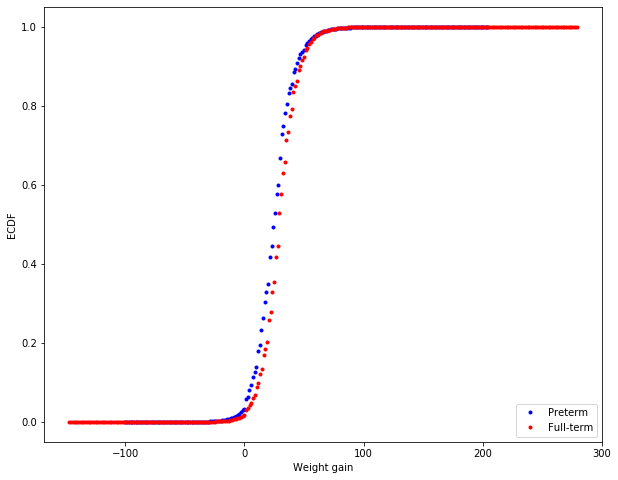

In [19]:
# ECDF weight gain of premature vs full-term
x_prem, y_prem = ecdf2(df[df.premature == True].weight_gain)
x_ft, y_ft = ecdf2(df[df.premature == False].weight_gain)

plt.plot(x_prem, y_prem, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ft, y_ft, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Weight gain')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

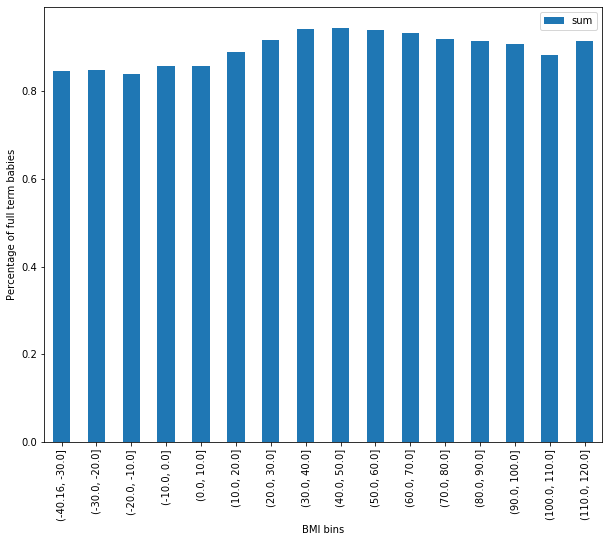

In [18]:
# Barplot of proportion of full term babies per weight gain of the mother
_ = for_plot.plot(kind='bar')
#_ = plt.xlim(-40, 120)  #limit to populations with at least 200 observations
_ = plt.xlabel("BMI bins")
_ = plt.ylabel("Percentage of full term babies")

As we can see, there is an optimum at BMI 30-60 (more than 86% of babies born full term). The ECDFs indicate the weight gain distribution for premature and full term populations are different.

Let's do an ANOVA on the two populations, comparing the means of the weight gains:

In [20]:
# ANOVA: mother weight gain of premature vs full-term
full_t = df[df.premature == False].weight_gain.dropna() 
premat = df[df.premature == True].weight_gain.dropna()
mean_full_t = np.mean(full_t)
mean_premat = np.mean(premat)
print('Mean weight gain for premature babies :', round(mean_premat, 2))
print('Mean weight gain for full-term babies :', round(mean_full_t, 2))

ANOVA_gain = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on weight gain of the mother between full-term and preterm babies is', round(ANOVA_gain[0], 2))
print('The p-value for the one-way ANOVA on weight gain of the mother between full-term and preterm babies is', round(ANOVA_gain[1], 4))

Mean weight gain for premature babies : 24.69
Mean weight gain for full-term babies : 29.07
The F-value for the one-way ANOVA on weight gain of the mother between full-term and preterm babies is 12969.7
The p-value for the one-way ANOVA on weight gain of the mother between full-term and preterm babies is 0.0


We reject the null hypothesis, the means of the two population are not equal.

The BMI follows the same trend, we will just run the ECDF and ANOVA:

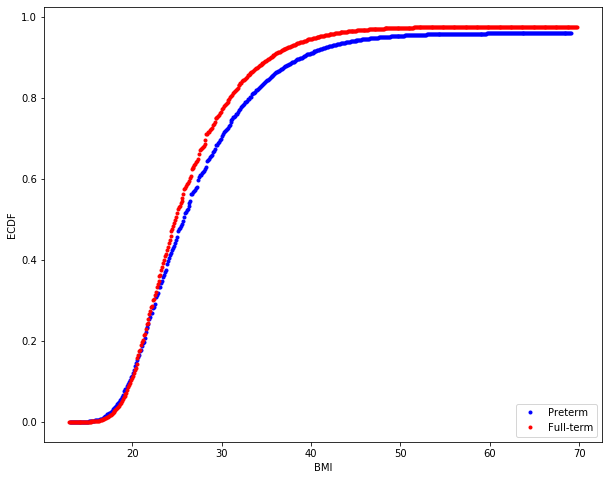

In [21]:
# ECDF BMI of premature vs full-term
x_prem, y_prem = ecdf2(df[df.premature == True].BMI)
x_ft, y_ft = ecdf2(df[df.premature == False].BMI)

plt.plot(x_prem, y_prem, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ft, y_ft, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('BMI')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

In [22]:
# ANOVA: mother BMI of premature vs full-term
full_t = df[df.premature == False].BMI.dropna() 
premat = df[df.premature == True].BMI.dropna()
mean_full_t = np.mean(full_t)
mean_premat = np.mean(premat)
print('Mean mother BMI for premature babies :', round(mean_premat, 2))
print('Mean mother BMI for full-term babies :', round(mean_full_t, 2))

ANOVA_BMI = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on BMI of the mother between full-term and preterm babies is', round(ANOVA_BMI[0], 2))
print('The p-value for the one-way ANOVA on BMI of the mother between full-term and preterm babies is', round(ANOVA_BMI[1], 4))

Mean mother BMI for premature babies : 26.81
Mean mother BMI for full-term babies : 26.0
The F-value for the one-way ANOVA on BMI of the mother between full-term and preterm babies is 2551.07
The p-value for the one-way ANOVA on BMI of the mother between full-term and preterm babies is 0.0


2. Effect of the age of the mother 

In a similar fashion, we can compare the delivery week (or, to simplify, the term of birth) by looking at the age of the mothers.

In [23]:
df.mother_age = df.mother_age.fillna(np.mean(df.mother_age)) 
df.obstetric_estimate = df.obstetric_estimate.fillna(39)
pear_age= st.pearsonr(df.mother_age, df.obstetric_estimate)
print('The correlation between age of the mother and delivery week is not strong at all with a Pearson coefficient of ', round(pear_age[0], 4))

The correlation between age of the mother and delivery week is not strong at all with a Pearson coefficient of  0.008


In [24]:
def p_true(data):
    p_true = np.divide(data.iloc[:,1], (data.iloc[:,0]+df_age.iloc[:,1]))
    return p_true

In [29]:
# proportion of full term babies per age in bims

df_age = df.groupby(['mother_age', "premature"]).obstetric_estimate.count()
df_age = df_age.unstack("premature")
df_age = df_age.reset_index().fillna(0)

df_age = df_age.groupby(df_age.mother_age).agg(['sum'])

#groups = df_age.groupby(pd.cut(df_age.mother_age, 10)).agg(['sum'])
#df_age = groups.stack()

for_plot = p_true(df_age)


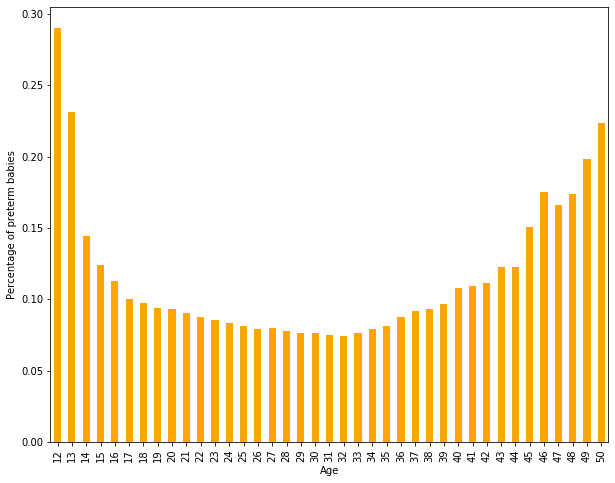

In [27]:
# Bar plot of percent of preterm babies per mother age
_ = for_plot.plot(kind='bar',color = 'orange')
_ = plt.xlabel("Age")
_ = plt.ylabel("Percentage of preterm babies")

In [66]:
# Hist of percent of full term babies per mother age
df_age = df[['mother_age', 'premature']]


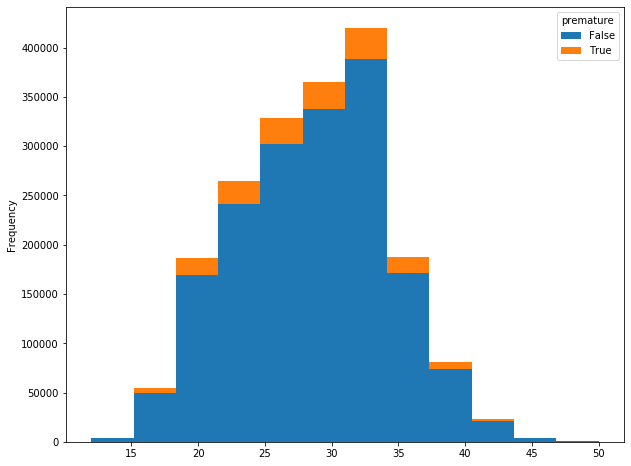

In [72]:
df_age.pivot(columns="premature", values="mother_age").plot.hist(bins=12, stacked = True)


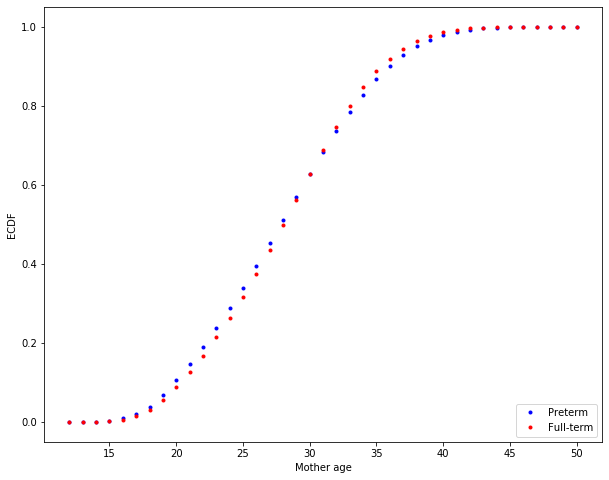

In [26]:
# ECDF mother age of premature vs full-term
x_prem, y_prem = ecdf2(df[df.premature == True].mother_age)
x_ft, y_ft = ecdf2(df[df.premature == False].mother_age)

plt.plot(x_prem, y_prem, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ft, y_ft, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Mother age')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

There is again an optimum with less premature births around 29-33 years old.
The ECDFs lead us to ANOVA testing:

In [27]:
# ANOVA: mother age of premature vs full-term
full_t = df[df.premature == False].mother_age
premat = df[df.premature == True].mother_age

mean_full_t = np.mean(full_t)
mean_premat = np.mean(premat)
print('Mean mother age for premature babies :', round(mean_premat, 2))
print('Mean mother age for full-term babies :', round(mean_full_t, 2))

ANOVA_age = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on age of the mother between full-term and preterm babies is', round(ANOVA_age[0], 2))
print('The p-value for the one-way ANOVA on age of the mother between full-term and preterm babies is', round(ANOVA_age[1], 4))

Mean mother age for premature babies : 28.4
Mean mother age for full-term babies : 28.47
The F-value for the one-way ANOVA on age of the mother between full-term and preterm babies is 21.52
The p-value for the one-way ANOVA on age of the mother between full-term and preterm babies is 0.0


In this case, the means are very close but the distributions are different. We see on the ECDFs that the spread is bigger for preterm babies (blue trace) than full term babies (red trace). 

3. Effect of tobacco

The distribution (ECDF) and mean delivery week seem different between smoker and non-smoker populations. One-way ANOVA confirms we reject the equality of means.

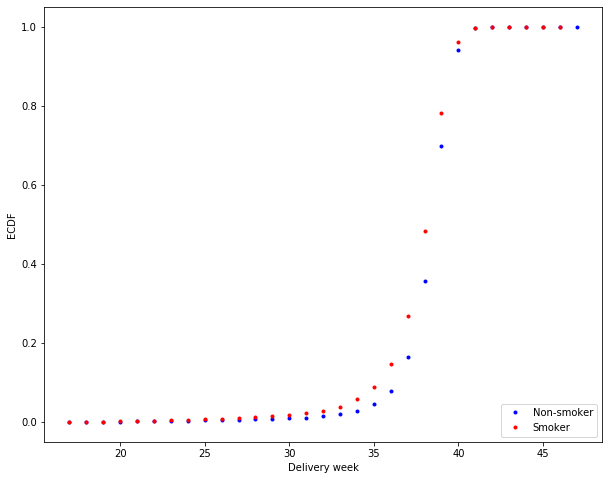

In [28]:
# ECDF delivery week of smoker vs non-smoker 
x_ns, y_ns = ecdf2(df[df.tobacco == 'N'].obstetric_estimate)
x_s, y_s = ecdf2(df[df.tobacco == 'Y'].obstetric_estimate)

plt.plot(x_ns, y_ns, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_s, y_s, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Non-smoker', 'Smoker'), loc='lower right')
plt.show()

In [29]:
# ANOVA: delivery week of smoker vs non-smoker 
non_smoker = df[df.tobacco == 'N'].obstetric_estimate.dropna() 
smoker = df[df.tobacco == 'Y'].obstetric_estimate.dropna()
mean_n_smok = np.mean(non_smoker)
mean_smok = np.mean(smoker)
print('Mean delivery week for smokers:', round(mean_smok, 2))
print('Mean delivery week for non-smokers:', round(mean_n_smok, 2))

ANOVA_smoke=st.f_oneway(non_smoker, smoker)
print('The F-value for the one-way ANOVA on delivery week between smokers and non-smokers is', round(ANOVA_smoke[0], 2))
print('The p-value for the one-way ANOVA on delivery week between smokers and non-smokers is', round(ANOVA_smoke[1], 4))

Mean delivery week for smokers: 38.04
Mean delivery week for non-smokers: 38.59
The F-value for the one-way ANOVA on delivery week between smokers and non-smokers is 7940.85
The p-value for the one-way ANOVA on delivery week between smokers and non-smokers is 0.0


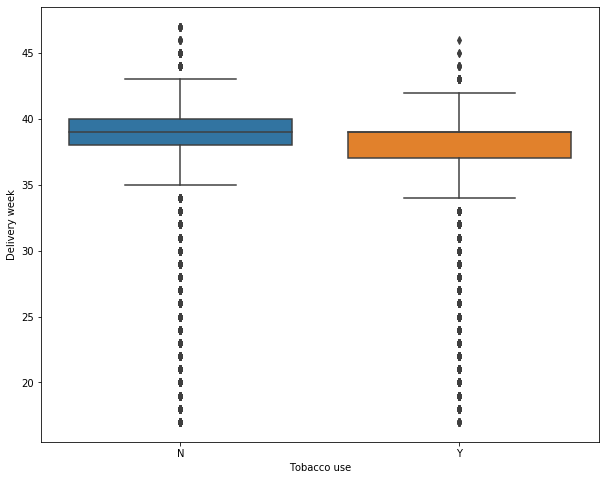

In [30]:
_ = sns.boxplot(x= 'tobacco', y= 'obstetric_estimate', data=df)
_ = plt.xlabel('Tobacco use')
_ = plt.ylabel('Delivery week')
plt.show()

4. Effect of mother race and hispanic origin

The distribution (ECDF) and mean delivery week are different for the six races. 

One-way ANOVA confirms we reject the equality of means.

In [19]:
# ANOVA: delivery week per races

white = df[df.mother_race == 1].obstetric_estimate.dropna() 
black = df[df.mother_race == 2].obstetric_estimate.dropna() 
AIAN = df[df.mother_race == 3].obstetric_estimate.dropna() 
asian = df[df.mother_race == 4].obstetric_estimate.dropna() 
NHOPI = df[df.mother_race == 5].obstetric_estimate.dropna() 
more = df[df.mother_race == 6].obstetric_estimate.dropna() 

mean_1 = np.mean(white)
mean_2 = np.mean(black)
mean_3 = np.mean(AIAN)
mean_4 = np.mean(asian)
mean_5 = np.mean(NHOPI)
mean_6 = np.mean(more)

print('Mean delivery week for babies of White mothers:', round(mean_1, 2))
print('Mean delivery week for babies of Black mothers:', round(mean_2, 2))
print('Mean delivery week for babies of AIAN mothers:', round(mean_3, 2))
print('Mean delivery week for babies of Asian mothers:', round(mean_4, 2))
print('Mean delivery week for babies of NHOPI mothers:', round(mean_5, 2))
print('Mean delivery week for babies of mothers of more than one race:', round(mean_6, 2))

ANOVA_race = st.f_oneway(white, black)

print('The F-value for the one-way ANOVA on delivery week between White and Black mothers is', round(ANOVA_race[0], 2))
print('The p-value for the one-way ANOVA on delivery week between White and Black mothers is', round(ANOVA_race[1], 4))

ANOVA_race1 = st.f_oneway(white,  asian)

print('The F-value for the one-way ANOVA on delivery week between White and Asian mothers is', round(ANOVA_race1[0], 2))
print('The p-value for the one-way ANOVA on delivery week between White and Asian mothers is', round(ANOVA_race1[1], 4))

ANOVA_race2 = st.f_oneway(white, black, AIAN, asian, NHOPI, more)

print('The F-value for the one-way ANOVA on delivery week between all six races is', round(ANOVA_race2[0], 2))
print('The p-value for the one-way ANOVA on delivery week between all six races is', round(ANOVA_race2[1], 4))

# ANOVA: obstetric estimate of mother hispanic origin
list_hisp = []

for i in range(0, 7):
    hisp = df[df.mother_hispanic == i].obstetric_estimate.dropna()
    mean_hisp = np.mean(hisp)
    print('Mean delivery week for mother hispanic origin ', i, 'is :', round(mean_hisp,2))
    list_hisp.append(hisp) 

a, b, c, d, e, f, g= tuple(list_hisp)    
ANOVA_hisp = st.f_oneway(a, b, c, d, e, f, g)

print('The F-value for the one-way ANOVA on delivery week between mother hispanic origins is', round(ANOVA_hisp[0], 2))
print('The p-value for the one-way ANOVA on delivery week between mother hispanic origins is', round(ANOVA_hisp[1], 4))

all_hisp_mean = np.mean(df[df.mother_hispanic != 0].obstetric_estimate.dropna())
print('Mean delivery week for mothers of all hispanic origins is :', round(all_hisp_mean,2))


Mean delivery week for babies of White mothers: 38.64
Mean delivery week for babies of Black mothers: 38.17
Mean delivery week for babies of AIAN mothers: 38.42
Mean delivery week for babies of Asian mothers: 38.56
Mean delivery week for babies of NHOPI mothers: 38.47
Mean delivery week for babies of mothers of more than one race: 38.52
The F-value for the one-way ANOVA on delivery week between White and Black mothers is 13299.51
The p-value for the one-way ANOVA on delivery week between White and Black mothers is 0.0
The F-value for the one-way ANOVA on delivery week between White and Asian mothers is 223.19
The p-value for the one-way ANOVA on delivery week between White and Asian mothers is 0.0
The F-value for the one-way ANOVA on delivery week between all six races is 2727.46
The p-value for the one-way ANOVA on delivery week between all six races is 0.0
Mean delivery week for mother hispanic origin  0 is : 38.56
Mean delivery week for mother hispanic origin  1 is : 38.55
Mean deli

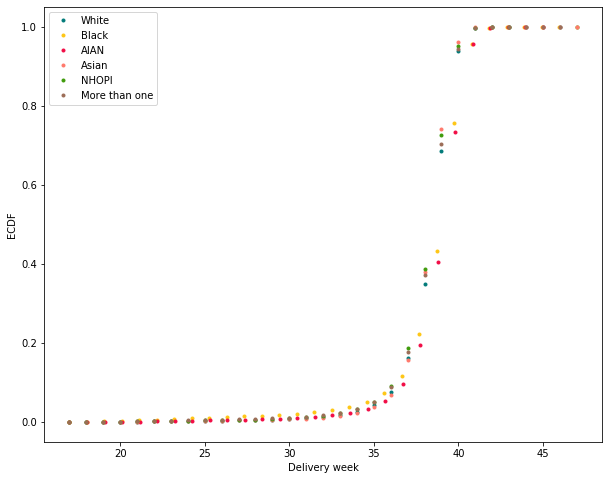

In [32]:
# ECDF delivery week by race
x_1, y_1 = ecdf2(df[df.mother_race == 1].obstetric_estimate)
x_2, y_2 = ecdf2(df[df.mother_race == 2].obstetric_estimate)
x_3, y_3 = ecdf2(df[df.mother_race == 3].obstetric_estimate)
x_4, y_4 = ecdf2(df[df.mother_race == 4].obstetric_estimate)
x_5, y_5 = ecdf2(df[df.mother_race == 5].obstetric_estimate)
x_6, y_6 = ecdf2(df[df.mother_race == 6].obstetric_estimate)

plt.plot(x_1, y_1, marker = '.', linestyle = 'None', color = 'xkcd:bluegreen')
plt.plot(x_2, y_2, marker = '.', linestyle = 'None', color = 'xkcd:golden yellow')
plt.plot(x_3, y_3, marker = '.', linestyle = 'None', color = 'xkcd:pinkish red')
plt.plot(x_4, y_4, marker = '.', linestyle = 'None', color = 'xkcd:salmon')
plt.plot(x_5, y_5, marker = '.', linestyle = 'None', color = 'xkcd:grass green')
plt.plot(x_6, y_6, marker = '.', linestyle = 'None', color = 'xkcd:brownish')
_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('White', 'Black', 'AIAN', 'Asian', "NHOPI", 'More than one'), loc='upper left')
plt.show()

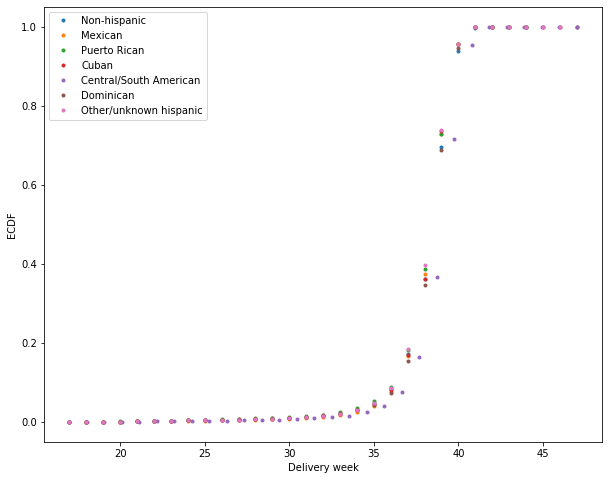

In [38]:
for i in range(0, 7):
    x, y = ecdf2(list_hisp[i])
    plt.plot(x, y, marker = '.', linestyle = 'None')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Non-hispanic', 'Mexican', 'Puerto Rican', 'Cuban', 'Central/South American', 'Dominican', 'Other/unknown hispanic'), loc='upper left')
plt.show()

5. Effect of risk factors and infections

The distribution (ECDF) and mean delivery week are different with or without risk factors, and with or without infection(s). This is expected, risk factors and infections lead to complications.

One-way ANOVA confirms that we reject the equality of means.

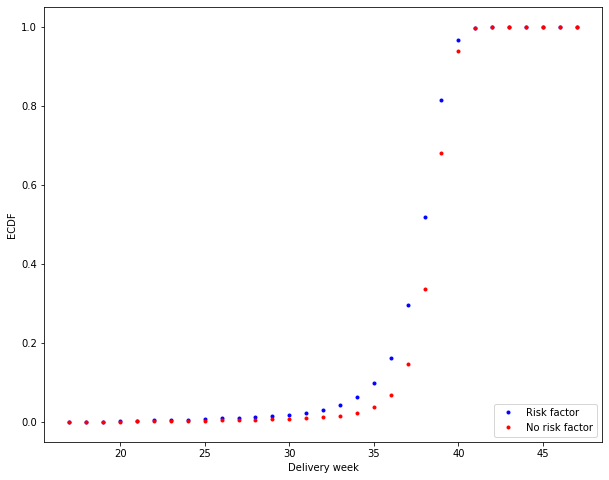

In [33]:
# ECDF delivery week with risk factors
x_risk, y_risk = ecdf2(df[df.no_risk_factors == 0].obstetric_estimate)
x_nrisk, y_nrisk = ecdf2(df[df.no_risk_factors == 1].obstetric_estimate)

plt.plot(x_risk, y_risk, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_nrisk, y_nrisk, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Risk factor', 'No risk factor'), loc='lower right')
plt.show()

In [34]:
# ANOVA: delivery week with risk factors
no_risk = df[df.no_risk_factors == 1].obstetric_estimate.dropna()
risk = df[df.no_risk_factors == 0].obstetric_estimate.dropna()
mean_nrisk = np.mean(no_risk)
mean_risk = np.mean(risk)


print('Mean delivery week with risk factor(s):', round(mean_risk, 2))
print('Mean delivery week with no risk factor(s):', round(mean_nrisk, 2))

ANOVA_risk=st.f_oneway(no_risk, risk)
print('The F-value for the one-way ANOVA on delivery week between mothers presenting risk factor(s) or no risks is', round(ANOVA_risk[0], 2))
print('The p-value for the one-way ANOVA on delivery week between mothers presenting risk factor(s) or no risks is', round(ANOVA_risk[1], 4))

Mean delivery week with risk factor(s): 37.89
Mean delivery week with no risk factor(s): 38.68
The F-value for the one-way ANOVA on delivery week between mothers presenting risk factor(s) or no risks is 40733.2
The p-value for the one-way ANOVA on delivery week between mothers presenting risk factor(s) or no risks is 0.0


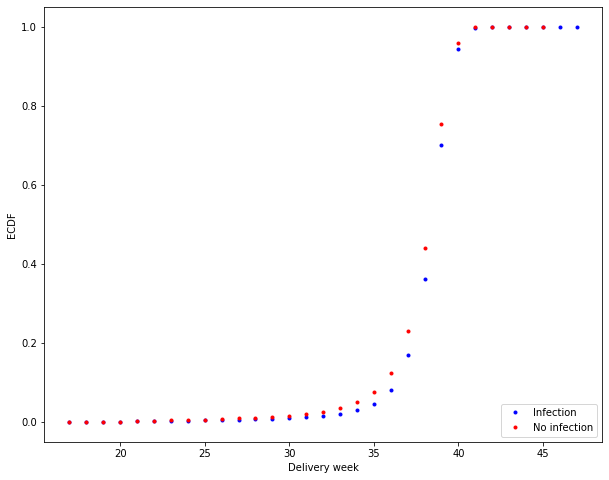

In [35]:
# ECDF delivery week with infection
no_inf = df[df.no_infection == 1].obstetric_estimate.dropna()
inf = df[df.no_infection == 0].obstetric_estimate.dropna()
x_inf, y_inf = ecdf2(no_inf)
x_ninf, y_ninf = ecdf2(inf)

plt.plot(x_inf, y_inf, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ninf, y_ninf, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Infection', 'No infection'), loc='lower right')
plt.show()



In [39]:
# ANOVA: delivery week with infection

mean_ninf = np.mean(no_inf)
mean_inf = np.mean(inf)


print('Mean delivery week with infection(s)):', round(mean_inf, 2))
print('Mean delivery week with no infection(s):', round(mean_ninf, 2))

ANOVA_inf=st.f_oneway(no_inf, inf)
print('The F-value for the one-way ANOVA on delivery week between mothers having an infection or not is', round(ANOVA_inf[0], 2))
print('The p-value for the one-way ANOVA on delivery week between mothers  having an infection or not is', round(ANOVA_inf[1], 4))

Mean delivery week with risk factor(s): 38.21
Mean delivery week with no risk factor(s): 38.57
The F-value for the one-way ANOVA on delivery week between mothers having an infection or not is 1669.11
The p-value for the one-way ANOVA on delivery week between mothers  having an infection or not is 0.0


6. Effect of previous preterm births

The distribution (ECDF) and mean delivery week are different with or without a previous preterm birth. 

One-way ANOVA confirms we reject the equality of means.

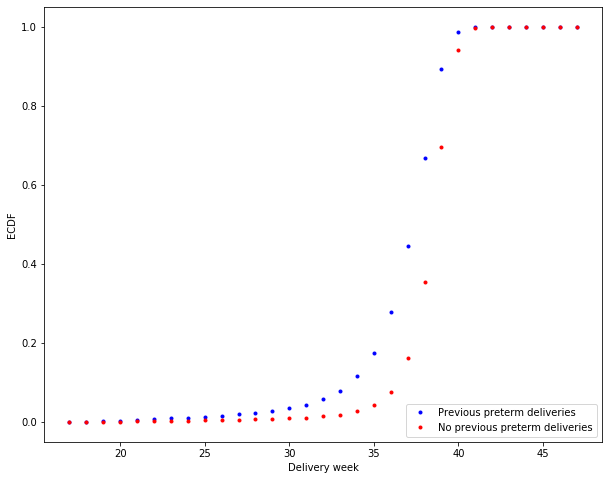

In [40]:
# ECDF delivery week with previous preterm births
x_noprev, y_noprev = ecdf2(df[df.previous_preterm_birth == 'N'].obstetric_estimate)
x_prev, y_prev = ecdf2(df[df.previous_preterm_birth == 'Y'].obstetric_estimate)

plt.plot(x_prev, y_prev, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_noprev, y_noprev, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Previous preterm deliveries', 'No previous preterm deliveries'), loc='lower right')
plt.show()

In [41]:
# ANOVA: delivery week with previous preterm births
no_prev = df[df.previous_preterm_birth == 'N'].obstetric_estimate
prev = df[df.previous_preterm_birth == 'Y'].obstetric_estimate
mean_nprev = np.mean(no_prev)
mean_prev = np.mean(prev)


print('Mean delivery week after previous preterm birth(s):', round(mean_prev, 2))
print('Mean delivery week without previous preterm birth:', round(mean_nprev, 2))

ANOVA_risk=st.f_oneway(no_prev, prev)
print('The F-value for the one-way ANOVA on delivery week between mothers having had a previous preterm birth and others is', round(ANOVA_smoke[0], 2))
print('The p-value for the one-way ANOVA on delivery week between mothers having had a previous preterm birth and others is', round(ANOVA_smoke[1], 4))

Mean delivery week after previous preterm birth(s): 37.09
Mean delivery week without previous preterm birth: 38.6
The F-value for the one-way ANOVA on delivery week between mothers having had a previous preterm birth and others is 7940.85
The p-value for the one-way ANOVA on delivery week between mothers having had a previous preterm birth and others is 0.0


7. Effect of birth order/time since previous pregnancy

The distribution (ECDF) indicate that the more babies you have, the more likely they are to be born early. Very short or long intervals between pregnancies seem to be linked to more premature births.

The two variable seem to have an impact, although not in a linear fashion (Pearson's coefficients are close to 0).


In [42]:
df_birthorder= df[['total_birth_order', 'obstetric_estimate']].dropna()
pear_age= st.pearsonr(df_birthorder.total_birth_order, df_birthorder.obstetric_estimate)
print('The correlation between the birth order and delivery week is not strong with a Pearson coefficient of ', round(pear_age[0], 4))

The correlation between the birth order and delivery week is not strong with a Pearson coefficient of  -0.0659


In [43]:
df_timeprev= df[['interval_since_last_pregnancy', 'obstetric_estimate']].dropna()
df_timeprev= df_timeprev[df_timeprev.interval_since_last_pregnancy < 888]
pear_age= st.pearsonr(df_timeprev.interval_since_last_pregnancy, df_timeprev.obstetric_estimate)
print('The correlation between the time since previous pregnancy and delivery week is not strong at all with a Pearson coefficient of ', round(pear_age[0], 4))

The correlation between the time since previous pregnancy and delivery week is not strong at all with a Pearson coefficient of  0.0045


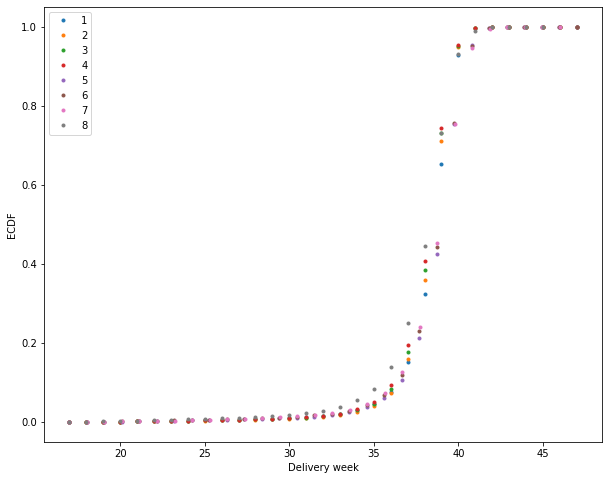

In [44]:
# ECDF delivery week by birth order
x_1, y_1 = ecdf2(df[df.total_birth_order == 1].obstetric_estimate)
x_2, y_2 = ecdf2(df[df.total_birth_order == 2].obstetric_estimate)
x_3, y_3 = ecdf2(df[df.total_birth_order == 3].obstetric_estimate)
x_4, y_4 = ecdf2(df[df.total_birth_order == 4].obstetric_estimate)
x_5, y_5 = ecdf2(df[df.total_birth_order == 5].obstetric_estimate)
x_6, y_6 = ecdf2(df[df.total_birth_order == 6].obstetric_estimate)
x_7, y_7 = ecdf2(df[df.total_birth_order == 7].obstetric_estimate)
x_8, y_8 = ecdf2(df[df.total_birth_order == 8].obstetric_estimate)


plt.plot(x_1, y_1, marker = '.', linestyle = 'None')
plt.plot(x_2, y_2, marker = '.', linestyle = 'None')
plt.plot(x_3, y_3, marker = '.', linestyle = 'None')
plt.plot(x_4, y_4, marker = '.', linestyle = 'None')
plt.plot(x_5, y_5, marker = '.', linestyle = 'None')
plt.plot(x_6, y_6, marker = '.', linestyle = 'None')
plt.plot(x_7, y_7, marker = '.', linestyle = 'None')
plt.plot(x_8, y_8, marker = '.', linestyle = 'None')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(range(1, 9), loc='upper left')
plt.show()

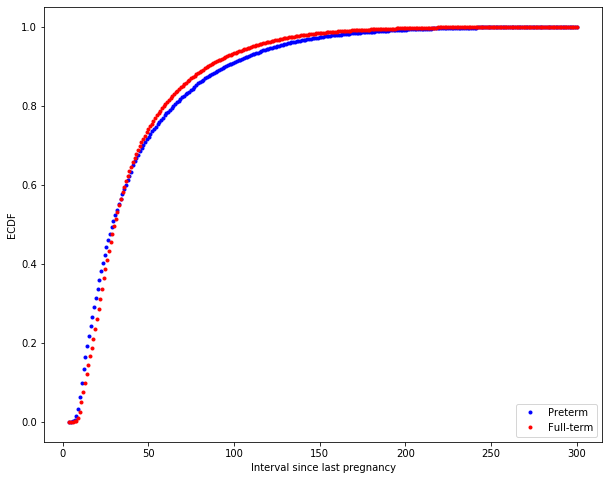

In [45]:
# ECDF interval since last preganacy of premature vs full-term
df_int = df[(df.interval_since_last_pregnancy > 3) & (df.interval_since_last_pregnancy < 888)]
x_prem, y_prem = ecdf2(df_int[df_int.premature == True].interval_since_last_pregnancy)
x_ft, y_ft = ecdf2(df_int[df_int.premature == False].interval_since_last_pregnancy)

plt.plot(x_prem, y_prem, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ft, y_ft, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Interval since last pregnancy')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

In [46]:
# ANOVA: delivery week per birth order

order1 = df[df.total_birth_order == 1].obstetric_estimate.dropna()
order2 = df[df.total_birth_order == 2].obstetric_estimate.dropna()
order3 = df[df.total_birth_order == 3].obstetric_estimate.dropna()
order4 = df[df.total_birth_order == 4].obstetric_estimate.dropna()
order5 = df[df.total_birth_order == 5].obstetric_estimate.dropna()
order6 = df[df.total_birth_order == 6].obstetric_estimate.dropna()
order7 = df[df.total_birth_order == 7].obstetric_estimate.dropna()
order8 = df[df.total_birth_order == 8].obstetric_estimate.dropna()

mean_1 = np.mean(order1)
mean_2 = np.mean(order2)
mean_3 = np.mean(order3)
mean_4 = np.mean(order4)
mean_5 = np.mean(order5)
mean_6 = np.mean(order6)
mean_7 = np.mean(order7)
mean_8 = np.mean(order8)



print('Mean delivery week for first borns:', round(mean_1, 2))
print('Mean delivery week for second babies:', round(mean_2, 2))
print('Mean delivery week for third babies:', round(mean_3, 2))
print('Mean delivery week for fourth babies:', round(mean_4, 2))
print('Mean delivery week for fifth babies:', round(mean_5, 2))
print('Mean delivery week for sixth babies:', round(mean_6, 2))
print('Mean delivery week for seventh babies:', round(mean_7, 2))
print('Mean delivery week for eighth or more babies:', round(mean_8, 2))

ANOVA_order = st.f_oneway(order1, order2, order3, order4, order5, order6, order7, order8)

print('The F-value for the one-way ANOVA on delivery week for all birth places is', round(ANOVA_order[0], 2))
print('The p-value for the one-way ANOVA on delivery week for all birth places is', round(ANOVA_order[1], 4))


ANOVA_order2 = st.f_oneway(order1, order8)

print('The F-value for the one-way ANOVA on delivery week between first born and eighth + is', round(ANOVA_order2[0], 2))
print('The p-value for the one-way ANOVA on delivery week for all first born and eighth + is', round(ANOVA_order2[1], 4))

Mean delivery week for first borns: 38.69
Mean delivery week for second babies: 38.6
Mean delivery week for third babies: 38.5
Mean delivery week for fourth babies: 38.42
Mean delivery week for fifth babies: 38.33
Mean delivery week for sixth babies: 38.25
Mean delivery week for seventh babies: 38.22
Mean delivery week for eighth or more babies: 38.18
The F-value for the one-way ANOVA on delivery week for all birth places is 1207.53
The p-value for the one-way ANOVA on delivery week for all birth places is 0.0
The F-value for the one-way ANOVA on delivery week between first born and eighth + is 2020.92
The p-value for the one-way ANOVA on delivery week for all first born and eighth + is 0.0


In [47]:
# ANOVA: interval since last pregnancy of premature vs full-term
full_t = df_int[df_int.premature == False].interval_since_last_pregnancy
premat = df_int[df_int.premature == True].interval_since_last_pregnancy

mean_full_t = np.mean(full_t)
mean_premat = np.mean(premat)
print('Mean interval since last pregnancy for premature babies :', round(mean_premat, 2))
print('Mean interval since last pregnancy for full-term babies :', round(mean_full_t, 2))

ANOVA_inter = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on interval since last pregnancy between full-term and preterm babies is', round(ANOVA_inter[0], 2))
print('The p-value for the one-way ANOVA on interval since last pregnancy between full-term and preterm babies is', round(ANOVA_inter[1], 4))

Mean interval since last pregnancy for premature babies : 43.04
Mean interval since last pregnancy for full-term babies : 41.86
The F-value for the one-way ANOVA on interval since last pregnancy between full-term and preterm babies is 92.0
The p-value for the one-way ANOVA on interval since last pregnancy between full-term and preterm babies is 0.0


8. Effect of the sex of the baby

The distribution (ECDF) indicate that boys are generally born earlier than girls. 


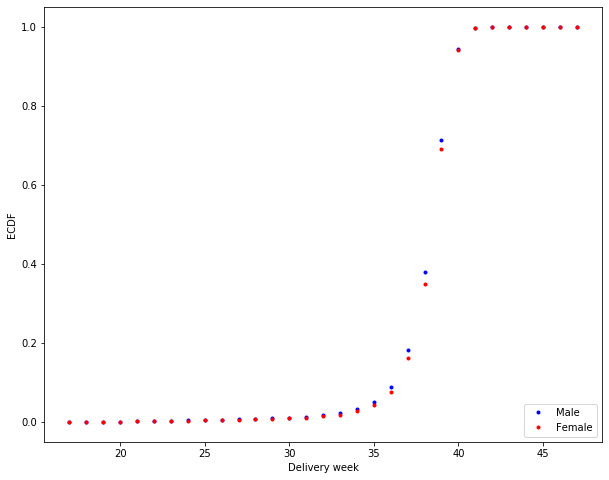

In [52]:
# ECDF delivery week per sex
male = df[df.sex == 'M'].obstetric_estimate.dropna()
female = df[df.sex == 'F'].obstetric_estimate.dropna()
x_male, y_male = ecdf2(male)
x_female, y_female = ecdf2(female)

plt.plot(x_male, y_male, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_female, y_female, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Male', 'Female'), loc='lower right')
plt.show()



In [53]:
# ANOVA: delivery week per sex
mean_m = np.mean(male)
mean_f = np.mean(female)


print('Mean delivery week for male children:', round(mean_m, 2))
print('Mean delivery week for female children:', round(mean_f, 2))

ANOVA_sex=st.f_oneway(male, female)
print('The F-value for the one-way ANOVA on delivery week between male and female children is', round(ANOVA_sex[0], 2))
print('The p-value for the one-way ANOVA on delivery week between male and female children is', round(ANOVA_sex[1], 4))

Mean delivery week for male children: 38.5
Mean delivery week for female children: 38.62
The F-value for the one-way ANOVA on delivery week between male and female children is 1663.56
The p-value for the one-way ANOVA on delivery week between male and female children is 0.0


9. Infertility treatment

In [67]:
# ANOVA: delivery week per infertility treatment
infert = df[df.ïnfertility_treatement == 'Y'].obstetric_estimate.dropna()
ninfert = df[df.ïnfertility_treatement == 'N'].obstetric_estimate.dropna()

mean_infert = np.mean(infert)
mean_ninfert = np.mean(ninfert)


print('Mean delivery week for parents having used infertility treatment:', round(mean_infert, 2))
print('Mean delivery week for parents not using infertility treatment:', round(mean_ninfert, 2))

ANOVA_infert=st.f_oneway(infert, ninfert)
print('The F-value for the one-way ANOVA on delivery week with and without infertility treatment is', round(ANOVA_infert[0], 2))
print('The p-value for the one-way ANOVA on delivery week with and without infertility treatment is', round(ANOVA_infert[1], 4))

Mean delivery week for parents having used infertility treatment: 37.83
Mean delivery week for parents not using infertility treatment: 38.57
The F-value for the one-way ANOVA on delivery week with and without infertility treatment is 3095.94
The p-value for the one-way ANOVA on delivery week with and without infertility treatment is 0.0


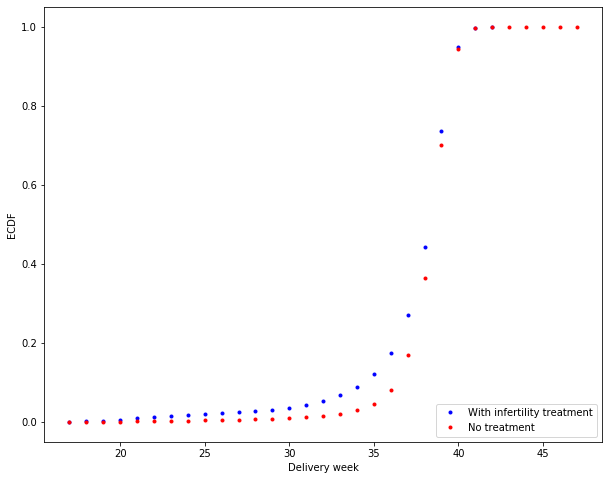

In [68]:
# ECDF delivery week per infertility treatment

x_infert, y_infert = ecdf2(infert)
x_ninfert, y_ninfert = ecdf2(ninfert)

plt.plot(x_infert, y_infert, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ninfert, y_ninfert, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('With infertility treatment', 'No treatment'), loc='lower right')
plt.show()



10. Plural birth

In [69]:
# ANOVA: delivery week per infertility treatment
singleton = df[df.plural_birth == 1].obstetric_estimate.dropna()
twin = df[df.plural_birth == 2].obstetric_estimate.dropna()
triplet = df[df.plural_birth == 3].obstetric_estimate.dropna()
quad = df[df.plural_birth == 4].obstetric_estimate.dropna()

mean_singleton = np.mean(singleton)
mean_twin = np.mean(twin)
mean_triplet = np.mean(triplet)
mean_quad = np.mean(quad)

print('Mean delivery week for parents having singleton:', round(mean_singleton, 2))
print('Mean delivery week for parents having twins:', round(mean_twin, 2))
print('Mean delivery week for parents having triplets:', round(mean_triplet, 2))
print('Mean delivery week for parents having quadruplets:', round(mean_quad, 2))

ANOVA_plural=st.f_oneway(singleton,twin,triplet,quad)
print('The F-value for the one-way ANOVA on delivery week based on plural birth is', round(ANOVA_plural[0], 2))
print('The p-value for the one-way ANOVA on delivery week based on plural birth is', round(ANOVA_plural[1], 4))

Mean delivery week for parents having singleton: 38.62
Mean delivery week for parents having twins: 34.34
Mean delivery week for parents having triplets: 28.29
Mean delivery week for parents having quadruplets: 30.13
The F-value for the one-way ANOVA on delivery week based on plural birth is 44238.87
The p-value for the one-way ANOVA on delivery week based on plural birth is 0.0


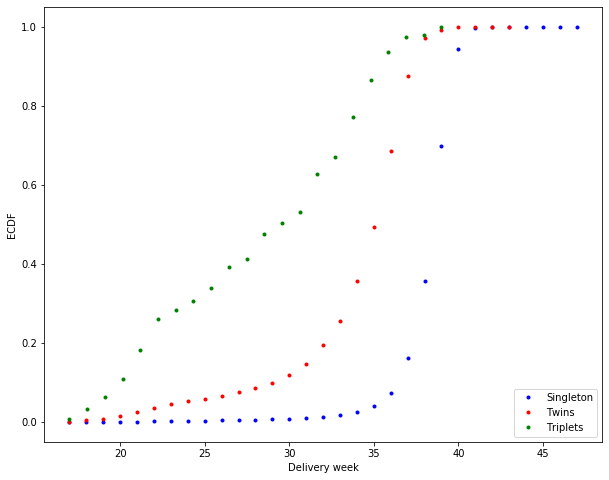

In [81]:
# ECDF delivery week per infertility treatment

x_sing, y_sing = ecdf2(singleton)
x_twin, y_twin = ecdf2(twin)
x_triplet, y_triplet = ecdf2(triplet)
#x_quad, y_quad = ecdf2(quad)

plt.plot(x_sing, y_sing, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_twin, y_twin, marker = '.', linestyle = 'None', color= 'red')
plt.plot(x_triplet, y_triplet, marker = '.', linestyle = 'None', color= 'green')
#plt.plot(x_quad, y_quad, marker = '.', linestyle = 'None')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Singleton', 'Twins', 'Triplets'), loc='lower right')
plt.show()

11. Congenital anomalies

In [84]:
# ANOVA: delivery week with(out) congenital anomalies
cong = df[df.no_congenital_anomalies == 0].obstetric_estimate.dropna()
ncong = df[df.no_congenital_anomalies == 1].obstetric_estimate.dropna()

print('Mean delivery week for babies presenting congenital anomalies:', round(np.mean(cong), 2))
print('Mean delivery week for babies presenting no congenital anomalies:', round(np.mean(ncong), 2))

ANOVA_cong=st.f_oneway(cong, ncong)
print('The F-value for the one-way ANOVA on delivery week with and without congenital anomalies is', round(ANOVA_cong[0], 2))
print('The p-value for the one-way ANOVA on delivery week with and without congenital anomalies is', round(ANOVA_cong[1], 4))


Mean delivery week for babies presenting congenital anomalies: 37.47
Mean delivery week for babies presenting no congenital anomalies: 38.56
The F-value for the one-way ANOVA on delivery week with and without congenital anomalies is 1465.57
The p-value for the one-way ANOVA on delivery week with and without congenital anomalies is 0.0


12. Effects of father characteristics

In [51]:
# Father age
full_t = df[df.premature == False].father_age.dropna()
premat = df[df.premature == True].father_age.dropna()

mean_full_t = np.mean(full_t)
mean_premat = np.mean(premat)
print('Mean father age for premature babies :', round(mean_premat, 2))
print('Mean father age for full-term babies :', round(mean_full_t, 2))

ANOVA_fage = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on age of the father between full-term and preterm babies is', round(ANOVA_fage[0], 2))
print('The p-value for the one-way ANOVA on age of the father between full-term and preterm babies is', round(ANOVA_fage[1], 4))

Mean father age for premature babies : 31.36
Mean father age for full-term babies : 31.36
The F-value for the one-way ANOVA on age of the father between full-term and preterm babies is 0.01
The p-value for the one-way ANOVA on age of the father between full-term and preterm babies is 0.9053


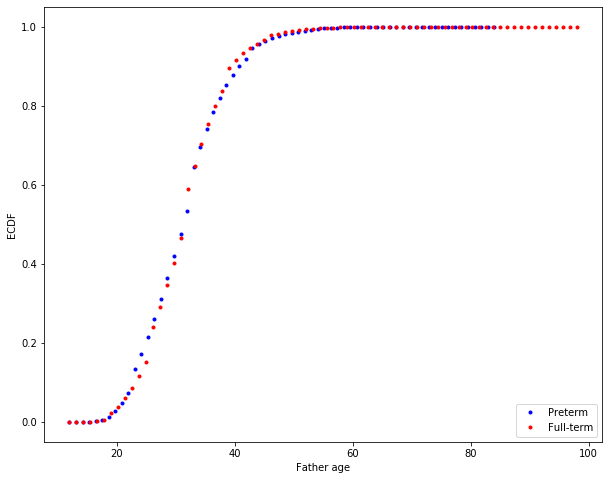

In [55]:
# ECDF father age of premature vs full-term
x_prem, y_prem = ecdf2(df[df.premature == True].father_age.dropna())
x_ft, y_ft = ecdf2(df[df.premature == False].father_age.dropna())

plt.plot(x_prem, y_prem, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ft, y_ft, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Father age')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

In [56]:
# ANOVA: delivery week per father race

list_frace = []

for i in range(1, 7):
    frace = df[df.father_race == i].obstetric_estimate.dropna()
    mean_frace = np.mean(frace)
    print('Mean delivery week for father race ', i, 'is :', round(mean_frace,2))
    list_frace.append(frace) 

a, b, c, d, e, f = tuple(list_frace)    
ANOVA_frace = st.f_oneway(a, b, c, d, e, f)

print('The F-value for the one-way ANOVA on delivery week between father races is', round(ANOVA_frace[0], 2))
print('The p-value for the one-way ANOVA on delivery week between father races is', round(ANOVA_frace[1], 4))

# ANOVA: obstetric estimate of father hispanic origin
list_fhisp = []

for i in range(0, 7):
    fhisp = df[df.father_hispanic == i].obstetric_estimate.dropna()
    mean_fhisp = np.mean(fhisp)
    print('Mean delivery week for father hispanic origin ', i, 'is :', round(mean_fhisp,2))
    list_fhisp.append(fhisp) 

a, b, c, d, e, f, g= tuple(list_fhisp)    
ANOVA_fhisp = st.f_oneway(a, b, c, d, e, f, g)

print('The F-value for the one-way ANOVA on delivery week between father hispanic origins is', round(ANOVA_fhisp[0], 2))
print('The p-value for the one-way ANOVA on delivery week between father hispanic origins is', round(ANOVA_fhisp[1], 4))




Mean delivery week for father race  1 is : 38.69
Mean delivery week for father race  2 is : 38.29
Mean delivery week for father race  3 is : 38.53
Mean delivery week for father race  4 is : 38.61
Mean delivery week for father race  5 is : 38.57
Mean delivery week for father race  6 is : 38.62
The F-value for the one-way ANOVA on delivery week between father races is 1657.12
The p-value for the one-way ANOVA on delivery week between father races is 0.0
Mean delivery week for father hispanic origin  0 is : 38.63
Mean delivery week for father hispanic origin  1 is : 38.56
Mean delivery week for father hispanic origin  2 is : 38.52
Mean delivery week for father hispanic origin  3 is : 38.55
Mean delivery week for father hispanic origin  4 is : 38.61
Mean delivery week for father hispanic origin  5 is : 38.62
Mean delivery week for father hispanic origin  6 is : 38.54
The F-value for the one-way ANOVA on delivery week between father hispanic origins is 83.24
The p-value for the one-way ANOV

In [89]:
# Calculate the percentage of interracial couples
df_mar = df[['mother_race', 'father_race']].dropna()
df_mar['interracial_marriage'] = df_mar.mother_race != df_mar.father_race
inter = df_mar.groupby(df_mar.interracial_marriage).count()
perc_inter = inter.iloc[1,0]/(inter.iloc[1,0] +inter.iloc[0,0])
print(perc_inter)

0.10481531754973551


### Socio-economical factors ##

1. Effect of marital status

Visual EDA identified a strong effect from the paternity acknowledgement on the delivery week. There are three statuses: Married (the husband is the legal father), parternity acknowledged (the person acknowledging is the legal father), and no paternity acknowledged (no legal father). The more involved the father, the lower the chances for premature birth.

In [62]:
# ANOVA: obstetric estimate of married vs unmarried
married = df[df.paternity_acknowledged == 'X'].obstetric_estimate.dropna()
father = df[df.paternity_acknowledged == 'Y'].obstetric_estimate.dropna()
no_father = df[df.paternity_acknowledged == 'N'].obstetric_estimate.dropna()


mean_marr = np.mean(married)
mean_fath = np.mean(father)
mean_nfath = np.mean(no_father)
print('Mean delivery week for babies of married parents:', round(mean_marr,2))
print('Mean delivery week for babies acknowledged by father:', round(mean_fath,2))
print('Mean delivery week for babies with no father acknowledgement :', round(mean_nfath,2))

ANOVA_mar = st.f_oneway(married, father, no_father)
print('The F-value for the one-way ANOVA on delivery week between children of married couples, children acknowledged by a father and children with no legal father is', round(ANOVA_mar[0], 2))
print('The p-value for the one-way ANOVA on delivery week between children of married couples, children acknowledged by a father and children with no legal father  is', round(ANOVA_mar[1], 4))

Mean delivery week for babies of married parents: 38.67
Mean delivery week for babies acknowledged by father: 38.41
Mean delivery week for babies with no father acknowledgement : 38.09
The F-value for the one-way ANOVA on delivery week between children of married couples, children acknowledged by a father and children with no legal father is 7615.16
The p-value for the one-way ANOVA on delivery week between children of married couples, children acknowledged by a father and children with no legal father  is 0.0


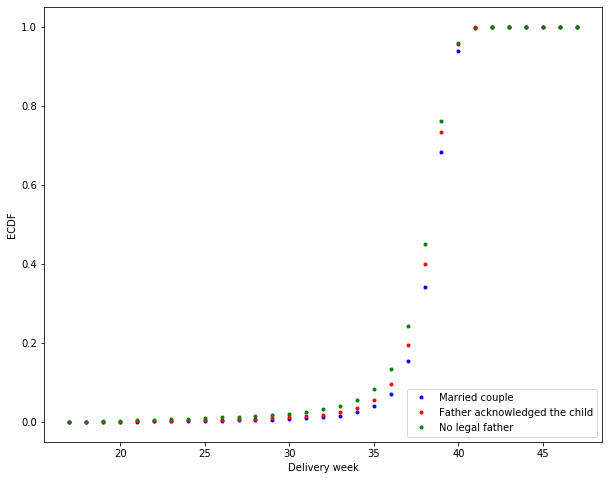

In [63]:
# ECDF delivery week per marital status
x_marr, y_marr = ecdf2(married)
x_father, y_father = ecdf2(father)
x_nfather, y_nfather = ecdf2(no_father)

plt.plot(x_marr, y_marr , marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_father, y_father, marker = '.', linestyle = 'None', color= 'red')
plt.plot(x_nfather, y_nfather, marker = '.', linestyle = 'None', color= 'green')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Married couple', 'Father acknowledged the child', 'No legal father'), loc='lower right')
plt.show()



2. Effect of mother and father education



In [100]:
# ANOVA: obstetric estimate of mother education
list_educ = []
list_mean = []

for i in range(1, 9):
    educ = df[df.mother_education == i].obstetric_estimate.dropna()
    mean_educ = np.mean(educ)
    print('Mean delivery week for mother education level ', i, 'is :', round(mean_educ,2))
    list_educ.append(educ) 
    list_mean.append(mean_educ)


a, b, c, d, e, f, g, h = tuple(list_educ)    
ANOVA_educ = st.f_oneway(a, b, c, d, e, f, g, h)

print('The F-value for the one-way ANOVA on delivery week between levels of mother education is', round(ANOVA_educ[0], 2))
print('The p-value for the one-way ANOVA on delivery week between levels of mother education is', round(ANOVA_educ[1], 4))

Mean delivery week for mother education level  1 is : 38.65
Mean delivery week for mother education level  2 is : 38.33
Mean delivery week for mother education level  3 is : 38.41
Mean delivery week for mother education level  4 is : 38.49
Mean delivery week for mother education level  5 is : 38.55
Mean delivery week for mother education level  6 is : 38.78
Mean delivery week for mother education level  7 is : 38.8
Mean delivery week for mother education level  8 is : 38.78
The F-value for the one-way ANOVA on delivery week between levels of mother education is 1956.75
The p-value for the one-way ANOVA on delivery week between levels of mother education is 0.0


In [101]:
# ANOVA: obstetric estimate of father education
list_feduc = []
list_fmean = []

for i in range(1, 9):
    feduc = df[df.father_education == i].obstetric_estimate.dropna()
    mean_feduc = np.mean(feduc)
    print('Mean delivery week for father education level ', i, 'is :', round(mean_feduc,2))
    list_feduc.append(feduc) 
    list_fmean.append(mean_feduc)

a, b, c, d, e, f, g, h = tuple(list_feduc)    
ANOVA_feduc = st.f_oneway(a, b, c, d, e, f, g, h)

print('The F-value for the one-way ANOVA on delivery week between levels of father education is', round(ANOVA_feduc[0], 2))
print('The p-value for the one-way ANOVA on delivery week between levels of father education is', round(ANOVA_feduc[1], 4))

Mean delivery week for father education level  1 is : 38.68
Mean delivery week for father education level  2 is : 38.43
Mean delivery week for father education level  3 is : 38.48
Mean delivery week for father education level  4 is : 38.59
Mean delivery week for father education level  5 is : 38.64
Mean delivery week for father education level  6 is : 38.8
Mean delivery week for father education level  7 is : 38.83
Mean delivery week for father education level  8 is : 38.82
The F-value for the one-way ANOVA on delivery week between levels of father education is 1364.93
The p-value for the one-way ANOVA on delivery week between levels of father education is 0.0


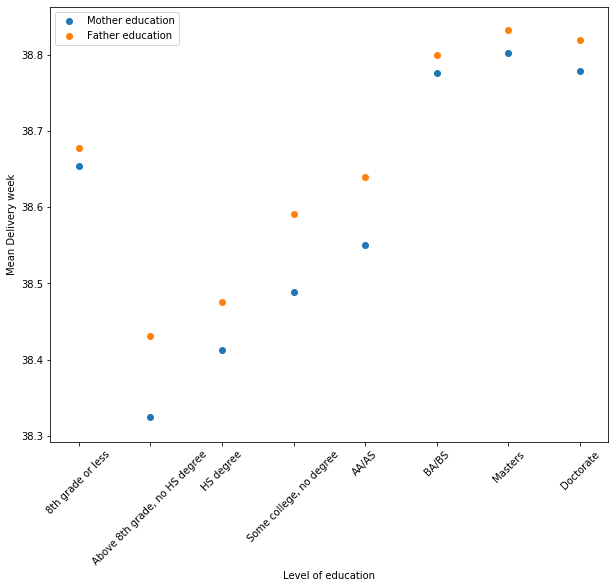

In [235]:
names = ['8th grade or less', 'Above 8th grade, no HS degree', 'HS degree', 'Some college, no degree', 'AA/AS', 'BA/BS', 'Masters', 'Doctorate']
_ = plt.scatter(names, list_mean)
_ = plt.scatter(names, list_fmean)
_= plt.xticks(rotation=45)
_ = plt.ylabel('Mean Delivery week')
_ = plt.xlabel('Level of education')
plt.legend(('Mother education', 'Father education'))
plt.show()

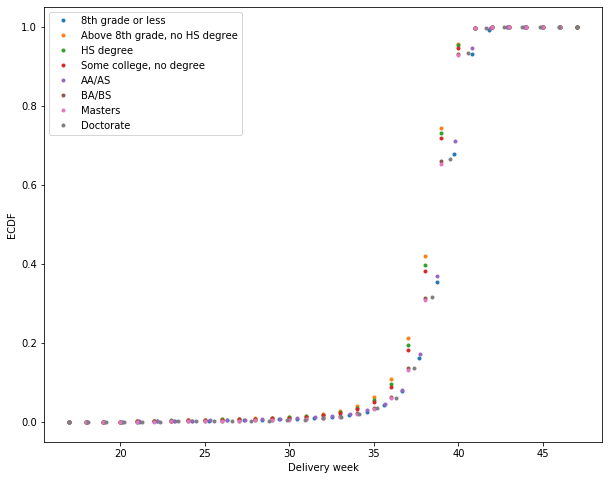

In [85]:
for i in range(0, 8):
    x, y = ecdf2(list_educ[i])
    plt.plot(x, y, marker = '.', linestyle = 'None')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('8th grade or less', 'Above 8th grade, no HS degree', 'HS degree', 'Some college, no degree', 'AA/AS', 'BA/BS', 'Masters', 'Doctorate'), loc='upper left')
plt.show()
    

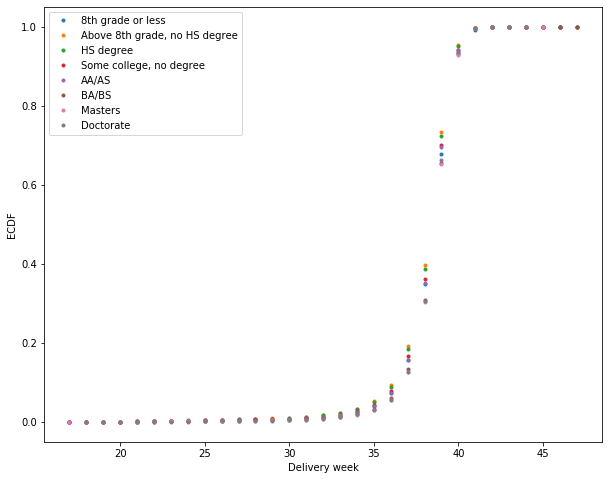

In [86]:
for i in range(0, 8):
    x, y = ecdf2(list_feduc[i])
    plt.plot(x, y, marker = '.', linestyle = 'None')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('8th grade or less', 'Above 8th grade, no HS degree', 'HS degree', 'Some college, no degree', 'AA/AS', 'BA/BS', 'Masters', 'Doctorate'), loc='upper left')
plt.show()

In [92]:
# Calculate the percentage of couples with the same education level
df_ed = df[['mother_education', 'father_education']].dropna()
df_ed['intereduc_marriage'] = df_ed.mother_education == df_ed.father_education
ed = df_ed.groupby(df_ed.intereduc_marriage).count()
perc_ed = ed.iloc[1,0]/(ed.iloc[1,0] +ed.iloc[0,0])
print(perc_ed)

0.44568318984915306


In [96]:
# Calculate the percentage of couples with education level +- 1
df_ed = df[['mother_education', 'father_education']].dropna()
df_ed['intereduc_marriage'] = ((df_ed.mother_education == df_ed.father_education) | (df_ed.mother_education == (df_ed.father_education - 1)) | (df_ed.mother_education == (df_ed.father_education + 1)))
ed = df_ed.groupby(df_ed.intereduc_marriage).count()
perc_ed = ed.iloc[1,0]/(ed.iloc[1,0] +ed.iloc[0,0])
print(perc_ed)

0.7687360580326409


3. Effect of WIC status


In [59]:
# ANOVA: obstetric estimate per WIC status
WIC = df[df.WIC == 'Y'].obstetric_estimate.dropna()
no_WIC = df[df.WIC == 'N'].obstetric_estimate.dropna()
print('Mean delivery week for mothers on WIC is :', round(np.mean(WIC),2))
print('Mean delivery week for mothers not on WIC is :', round(np.mean(no_WIC),2))
  
ANOVA_WIC = st.f_oneway(WIC, no_WIC)

print('The F-value for the one-way ANOVA on delivery week between WIC statuses is', round(ANOVA_WIC[0], 2))
print('The p-value for the one-way ANOVA on delivery week between WIC statuses is', round(ANOVA_WIC[1], 4))

Mean delivery week for mothers on WIC is : 38.46
Mean delivery week for mothers not on WIC is : 38.62
The F-value for the one-way ANOVA on delivery week between WIC statuses is 2536.41
The p-value for the one-way ANOVA on delivery week between WIC statuses is 0.0


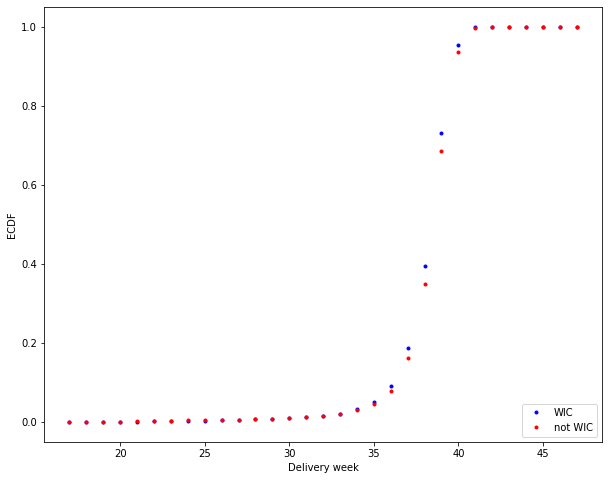

In [60]:
# ECDF delivery week per WIC
x_WIC, y_WIC = ecdf2(WIC)
x_nWIC, y_nWIC = ecdf2(no_WIC)

plt.plot(x_WIC, y_WIC, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_nWIC, y_nWIC, marker = '.', linestyle = 'None', color= 'red')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('WIC', 'not WIC'), loc='lower right')
plt.show()



4. Effect of payement method



In [87]:
# ANOVA: obstetric estimate of mother education
list_pay = []

for i in range(1, 5):
    pay = df[df.payment == i].obstetric_estimate.dropna()
    mean_pay = np.mean(pay)
    print('Mean delivery week for payment type ', i, 'is :', round(mean_pay,2))
    list_pay.append(pay) 

a, b, c, d = tuple(list_pay)    
ANOVA_pay = st.f_oneway(a, b, c, d)

print('The F-value for the one-way ANOVA on delivery week between payment methods is', round(ANOVA_pay[0], 2))
print('The p-value for the one-way ANOVA on delivery week between payment methods is', round(ANOVA_pay[1], 4))

Mean delivery week for payment type  1 is : 38.4
Mean delivery week for payment type  2 is : 38.67
Mean delivery week for payment type  3 is : 38.82
Mean delivery week for payment type  4 is : 38.58
The F-value for the one-way ANOVA on delivery week between payment methods is 3229.27
The p-value for the one-way ANOVA on delivery week between payment methods is 0.0


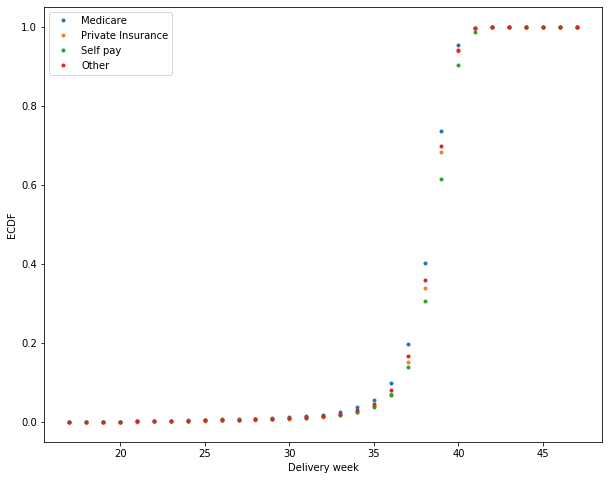

In [88]:
for i in range(0, 4):
    x, y = ecdf2(list_pay[i])
    plt.plot(x, y, marker = '.', linestyle = 'None')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Medicare', 'Private Insurance', 'Self pay', 'Other'), loc='upper left')
plt.show()

5. Effect of place of birth (hospital or not)

In [90]:
list_place = []

for i in range(1, 8):
    place = df[df.birth_place == i].obstetric_estimate.dropna()
    mean_place = np.mean(place)
    print('Mean delivery week for place of birth type ', i, 'is :', round(mean_place,2))
    list_place.append(place) 

a, b, c, d, e, f, g = tuple(list_place)    
ANOVA_place = st.f_oneway(a, b, c, d,  e, f, g)

print('The F-value for the one-way ANOVA on delivery week between places of birth is', round(ANOVA_place[0], 2))
print('The p-value for the one-way ANOVA on delivery week between places of birth is', round(ANOVA_place[1], 4))

Mean delivery week for place of birth type  1 is : 38.53
Mean delivery week for place of birth type  2 is : 39.6
Mean delivery week for place of birth type  3 is : 39.73
Mean delivery week for place of birth type  4 is : 37.5
Mean delivery week for place of birth type  5 is : 39.22
Mean delivery week for place of birth type  6 is : 39.14
Mean delivery week for place of birth type  7 is : 38.3
The F-value for the one-way ANOVA on delivery week between places of birth is 2896.2
The p-value for the one-way ANOVA on delivery week between places of birth is 0.0


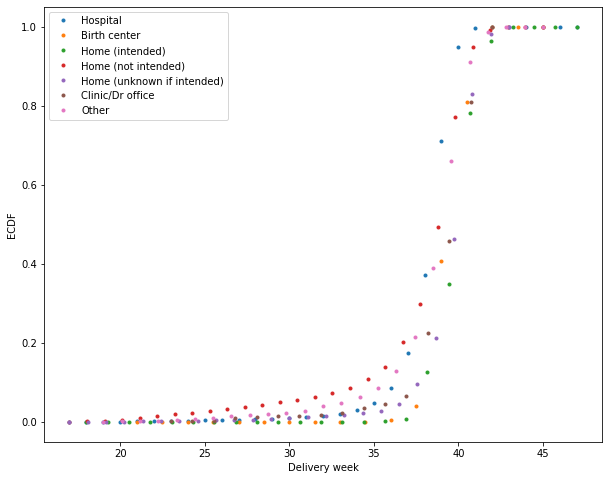

In [92]:

for i in range(0, 7):
    x, y = ecdf2(list_place[i])
    plt.plot(x, y, marker = '.', linestyle = 'None')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Hospital', 'Birth center', 'Home (intended)', 'Home (not intended)', 'Home (unknown if intended)', 'Clinic/Dr office', 'Other'), loc='upper left')
plt.show()

### Other factors ##



1. Effect of mother nativity

In [89]:
# ANOVA: obstetric estimate per natality status (in/outside the US)
US = df[df.mother_nativity == 1].obstetric_estimate.dropna()
no_US = df[df.mother_nativity == 2].obstetric_estimate.dropna()
print('Mean delivery week for mothers born in the US is :', round(np.mean(US),2))
print('Mean delivery week for mothers not born in the US is :', round(np.mean(no_US),2))
  
ANOVA_US = st.f_oneway(US, no_US)

print('The F-value for the one-way ANOVA on delivery week between mothers born inside and outside the US is', round(ANOVA_US[0], 2))
print('The p-value for the one-way ANOVA on delivery week between mothers born inside and outside the US is', round(ANOVA_US[1], 4))




Mean delivery week for mothers born in the US is : 38.54
Mean delivery week for mothers not born in the US is : 38.63
The F-value for the one-way ANOVA on delivery week between mothers born inside and outside the US is 714.47
The p-value for the one-way ANOVA on delivery week between mothers born inside and outside the US is 0.0


2. Month prenatal care began and number of visits

In [118]:
# Prenatal care begins
full_t = df[df.premature == False].month_prenatal_care_began.dropna()
premat = df[df.premature == True].month_prenatal_care_began.dropna()

print('Mean month prenatal care began for full-term premature babies :', round(np.mean(full_t), 2))
print('Mean month prenatal care began for premature babies :', round(np.mean(premat), 2))

ANOVA_prenat = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on month prenatal care began between full-term and preterm babies is', round(ANOVA_prenat[0], 2))
print('The p-value for the one-way ANOVA on month prenatal care began between full-term and preterm babies is', round(ANOVA_prenat[1], 4))


Mean month prenatal care began for full-term premature babies : 2.93
Mean month prenatal care began for premature babies : 2.69
The F-value for the one-way ANOVA on month prenatal care began between full-term and preterm babies is 3203.62
The p-value for the one-way ANOVA on month prenatal care began between full-term and preterm babies is 0.0


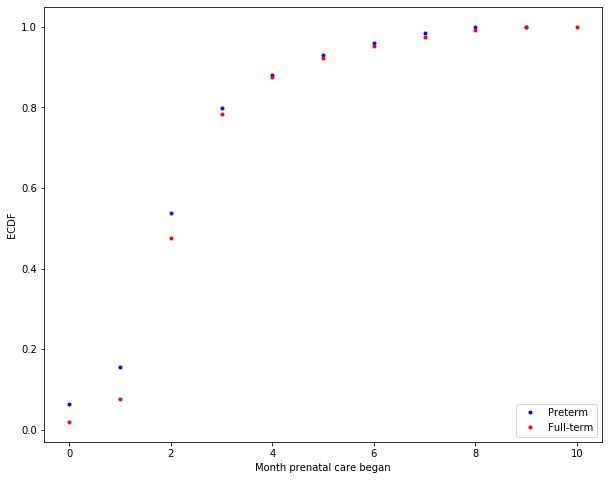

In [119]:
# ECDF month care began of premature vs full-term
x_prem, y_prem = ecdf2(premat)
x_ft, y_ft = ecdf2(full_t)

plt.plot(x_prem, y_prem, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ft, y_ft, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Month prenatal care began')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

In [121]:
# Number of visits
df['visits_month'] = df.number_prenatal_visits/(df.obstetric_estimate)


full_t = df[df.premature == False]
full_t = full_t[['number_prenatal_visits', 'obstetric_estimate']]
full_t['visits_month'] = full_t.number_prenatal_visits/(full_t.obstetric_estimate)


premat = df[df.premature == True]
premat = premat[['number_prenatal_visits', 'obstetric_estimate']]
premat['visits_month'] = premat.number_prenatal_visits/(premat.obstetric_estimate)

print('Mean number of prenatal visits for full-term babies :', round(np.mean(full_t.number_prenatal_visits), 2))
print('Mean number of prenatal visits for premature babies :', round(np.mean(premat.number_prenatal_visits), 2))

print('Mean number of prenatal visits per week for full-term babies :', round(np.mean(full_t.visits_month), 2))
print('Mean number of prenatal visits per week for premature babies :', round(np.mean(premat.visits_month), 2))

ANOVA_prenatal_visits = st.f_oneway(full_t.number_prenatal_visits.dropna(), premat.number_prenatal_visits.dropna())
print('The F-value for the one-way ANOVA on number of prenatal visits between full-term and preterm babies is', round(ANOVA_prenatal_visits[0], 2))
print('The p-value for the one-way ANOVA on number of prenatal visits between full-term and preterm babies is', round(ANOVA_prenatal_visits[1], 4))

ANOVA_visits_month = st.f_oneway(full_t.visits_month.dropna(), premat.visits_month.dropna())
print('The F-value for the one-way ANOVA on number of prenatal visits per week between full-term and preterm babies is', round(ANOVA_visits_month[0], 2))
print('The p-value for the one-way ANOVA on number of prenatal visits per week between full-term and preterm babies is', round(ANOVA_visits_month[1], 4))



Mean number of prenatal visits for full-term babies : 11.14
Mean number of prenatal visits for premature babies : 8.82
Mean number of prenatal visits per week for full-term babies : 0.29
Mean number of prenatal visits per week for premature babies : 0.26
The F-value for the one-way ANOVA on number of prenatal visits between full-term and preterm babies is 46124.08
The p-value for the one-way ANOVA on number of prenatal visits between full-term and preterm babies is 0.0
The F-value for the one-way ANOVA on number of prenatal visits per week between full-term and preterm babies is 9085.31
The p-value for the one-way ANOVA on number of prenatal visits per week between full-term and preterm babies is 0.0


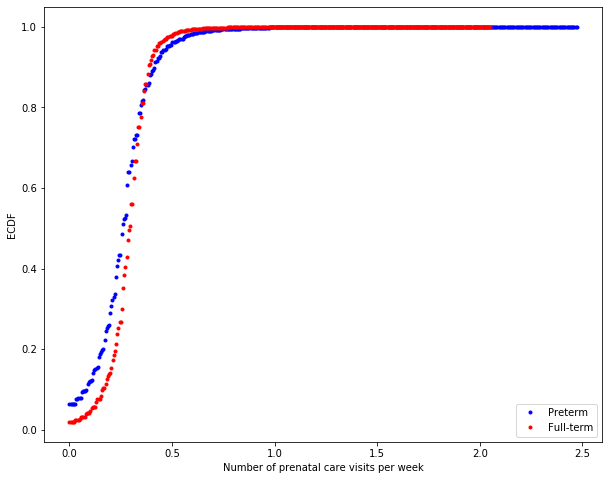

In [123]:
# ECDF month care began of premature vs full-term
x_prem, y_prem = ecdf2(premat.visits_month.dropna())
x_ft, y_ft = ecdf2(full_t.visits_month.dropna())

plt.plot(x_prem, y_prem, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_ft, y_ft, marker = '.', linestyle = 'None', color= 'red')
_ = plt.xlabel('Number of prenatal care visits per week')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

3. Delivery method

In [98]:
# ANOVA: obstetric estimate of vaginal and c-section deliveries
vag = df[df.delivery_method == 1].obstetric_estimate.dropna()
ceas = df[df.delivery_method == 2].obstetric_estimate.dropna()


print('Mean delivery week for vaginal deliveries:', round(np.mean(vag),2))
print('Mean delivery week for c-sections:', round(np.mean(ceas),2))

ANOVA_meth = st.f_oneway(vag, ceas)
print('The F-value for the one-way ANOVA on delivery week between vaginal and c-section deliveries is', round(ANOVA_meth[0], 2))
print('The p-value for the one-way ANOVA on delivery week between vaginal and c-section deliveries is', round(ANOVA_meth[1], 4))

Mean delivery week for vaginal deliveries: 38.56
Mean delivery week for c-sections: 38.49
The F-value for the one-way ANOVA on delivery week between vaginal and c-section deliveries is 207.12
The p-value for the one-way ANOVA on delivery week between vaginal and c-section deliveries is 0.0


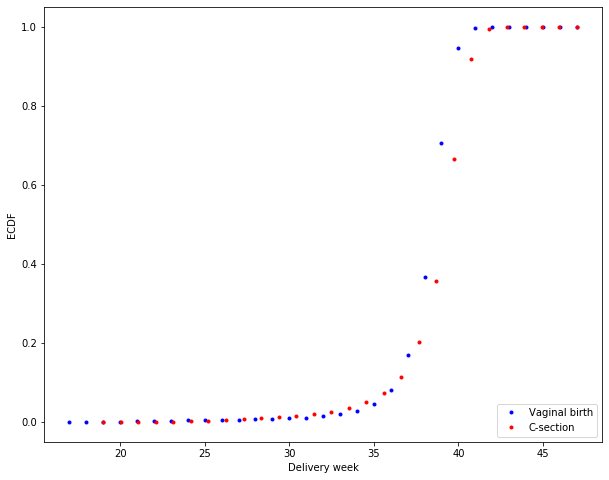

In [99]:
a = vag
b = ceas
x_a, y_a = ecdf2(a)
x_b, y_b = ecdf2(b)

plt.plot(x_a, y_a, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_b, y_b, marker = '.', linestyle = 'None', color= 'red')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Vaginal birth', 'C-section'), loc='lower right')
plt.show()

4. Breastfeeding

In [94]:
# ANOVA: obstetric estimate of married vs unmarried
BF = df[df.breastfed == 'Y'].obstetric_estimate.dropna()
n_BF = df[df.breastfed == 'N'].obstetric_estimate.dropna()


print('Mean delivery week for breastfed babies:', round(np.mean(BF),2))
print('Mean delivery week for non-breastfed babies:', round(np.mean(n_BF),2))

ANOVA_BF = st.f_oneway(BF, n_BF)
print('The F-value for the one-way ANOVA on delivery week between breastfed and formula fed babies is', round(ANOVA_BF[0], 2))
print('The p-value for the one-way ANOVA on delivery week between breastfed and formula fed babies is', round(ANOVA_BF[1], 4))

Mean delivery week for breastfed babies: 38.67
Mean delivery week for non-breastfed babies: 37.88
The F-value for the one-way ANOVA on delivery week between breastfed and formula fed babies is 35439.25
The p-value for the one-way ANOVA on delivery week between breastfed and formula fed babies is 0.0


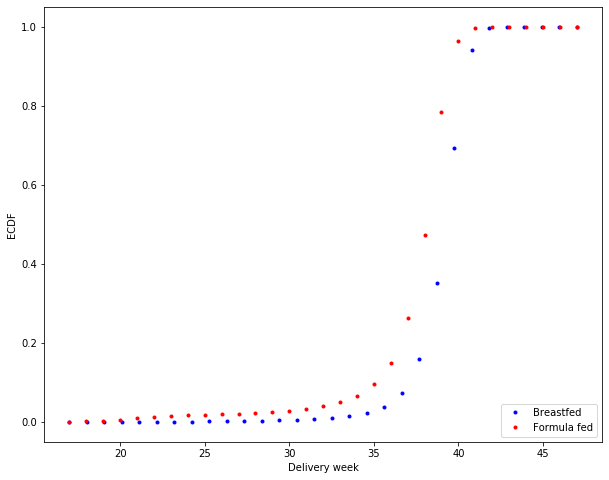

In [95]:
x_BF, y_BF = ecdf2(BF)
x_n_BF, y_n_BF = ecdf2(n_BF)

plt.plot(x_BF, y_BF, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_n_BF, y_n_BF, marker = '.', linestyle = 'None', color= 'red')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('Breastfed', 'Formula fed'), loc='lower right')
plt.show()

### Factors thought to not have an impact, purely random###
1. Weekday of birth

In [12]:
# ANOVA: weekday of birth of premature vs full-term
full_t = df[df.premature == False].birth_weekday.dropna() 
premat = df[df.premature == True].birth_weekday.dropna()
mean_full_t = np.mean(full_t)
mean_premat = np.mean(premat)
print('Mean weekday for premature babies :', round(mean_premat, 2))
print('Mean weekday for full-term babies :', round(mean_full_t, 2))

ANOVA_weekday = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on weekday of birth between full-term and preterm babies is', round(ANOVA_weekday[0], 2))
print('The p-value for the one-way ANOVA on weekday of birth between full-term and preterm babies is', round(ANOVA_weekday[1], 4))

Mean weekday for premature babies : 4.02
Mean weekday for full-term babies : 4.02
The F-value for the one-way ANOVA on weekday of birth between full-term and preterm babies is 1.92
The p-value for the one-way ANOVA on weekday of birth between full-term and preterm babies is 0.1661


2. Birth time

In [30]:
# ANOVA: birth time of premature vs full-term
full_t = df[df.premature == False].birth_time.dropna() 
premat = df[df.premature == True].birth_time.dropna()
mean_full_t = np.mean(full_t)
mean_premat = np.mean(premat)
print('Mean birth time for premature babies :', round(mean_premat, 2))
print('Mean birth time for full-term babies :', round(mean_full_t, 2))

ANOVA_time = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on birth time between full-term and preterm babies is', round(ANOVA_time[0], 2))
print('The p-value for the one-way ANOVA on birth time between full-term and preterm babies is', round(ANOVA_time[1], 4))

Mean birth time for premature babies : 1214.16
Mean birth time for full-term babies : 1204.04
The F-value for the one-way ANOVA on birth time between full-term and preterm babies is 33.36
The p-value for the one-way ANOVA on birth time between full-term and preterm babies is 0.0


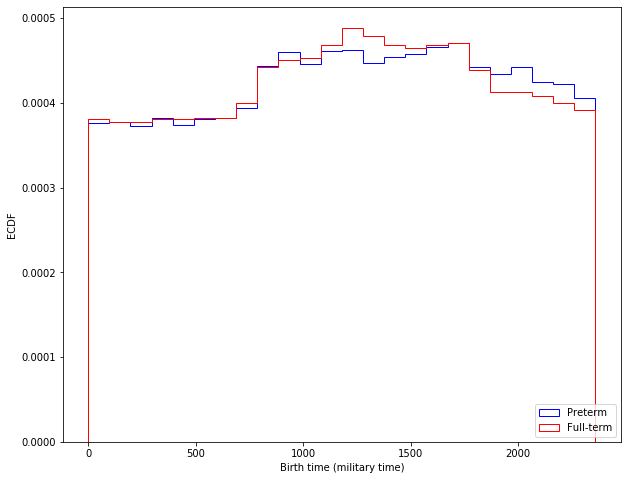

In [51]:
plt.hist(premat, color= 'blue', histtype = 'step', bins = 24, density=True)
plt.hist(full_t, color= 'red', histtype = 'step', bins = 24, density = True)
_ = plt.xlabel('Birth time (military time)')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

3. Birth month

In [14]:
# ANOVA: birth month of premature vs full-term
full_t = df[df.premature == False].birth_month.dropna() 
premat = df[df.premature == True].birth_month.dropna()
mean_full_t = np.mean(full_t)
mean_premat = np.mean(premat)
print('Mean birth month for premature babies :', round(mean_premat, 2))
print('Mean birth month for full-term babies :', round(mean_full_t, 2))

ANOVA_month = st.f_oneway(full_t, premat)
print('The F-value for the one-way ANOVA on birth month between full-term and preterm babies is', round(ANOVA_month[0], 2))
print('The p-value for the one-way ANOVA on birth month between full-term and preterm babies is', round(ANOVA_month[1], 4))

Mean birth month for premature babies : 6.56
Mean birth month for full-term babies : 6.54
The F-value for the one-way ANOVA on birth month between full-term and preterm babies is 5.0
The p-value for the one-way ANOVA on birth month between full-term and preterm babies is 0.0253


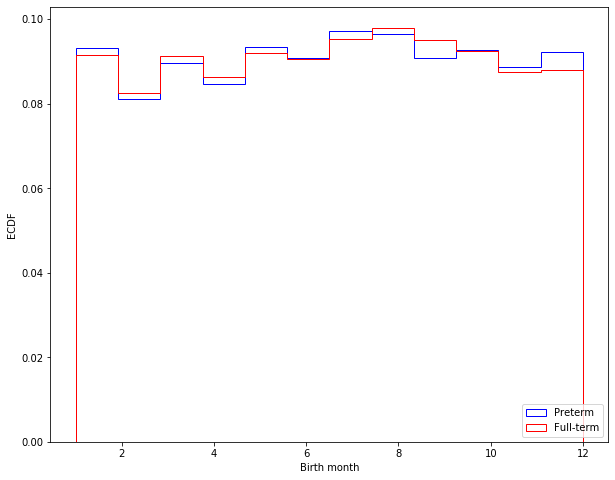

In [29]:
# ECDF premature vs full-term

plt.hist(premat, color= 'blue', histtype = 'step', bins = 12, density=True)
plt.hist(full_t, color= 'red', histtype = 'step', bins = 12, density = True)
_ = plt.xlabel('Birth month')
_ = plt.ylabel('ECDF')
plt.legend(('Preterm', 'Full-term'), loc='lower right')
plt.show()

### Outcomes ###

1. Abnormal conditions

In [101]:
abnor = df[df.no_abnormal_condition == 0].obstetric_estimate.dropna()
n_abnor = df[df.no_abnormal_condition == 1].obstetric_estimate.dropna()

a = abnor
b = n_abnor

print('Mean delivery week without abnormal condition:', round(np.mean(a),2))
print('Mean delivery week with abnormal condition:', round(np.mean(b),2))

ANOVA_abnor = st.f_oneway(a, b)
print('The F-value for the one-way ANOVA on delivery week with/without abnormal condition is', round(ANOVA_abnor[0], 2))
print('The p-value for the one-way ANOVA on delivery week with/without abnormal condition is', round(ANOVA_abnor[1], 4))

Mean delivery week without abnormal condition: 36.28
Mean delivery week with abnormal condition: 38.77
The F-value for the one-way ANOVA on delivery week with/without abnormal condition is 258011.57
The p-value for the one-way ANOVA on delivery week with/without abnormal condition is 0.0


In [181]:
abnormal = df.groupby(('premature', 'no_abnormal_condition')).no_abnormal_condition.count()
print(abnormal)

prop_PA = abnormal[1,0]/(abnormal[1,0]+abnormal[1,1])
prop_FA = abnormal[0,0]/(abnormal[0,0]+abnormal[0,1])

print(prop_PA, prop_FA)

premature  no_abnormal_condition
False      0.0                        94102
           1.0                      1665811
True       0.0                        69640
           1.0                        89976
Name: no_abnormal_condition, dtype: int64
0.4362971130713713 0.053469688558468516


/Users/berenice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [ ]:
abnormal.unstack
abnormal.to_frame()

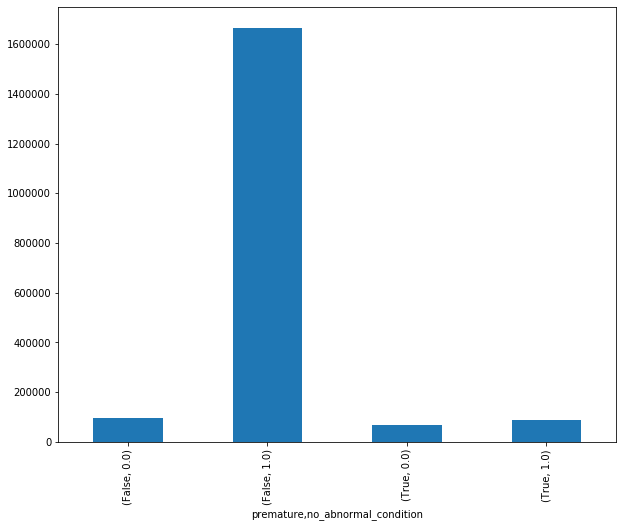

In [188]:
abnormal.plot(kind='bar')
#plt.bar(abnormal.index, abnormal.no_abnormal_condition)
plt.show()

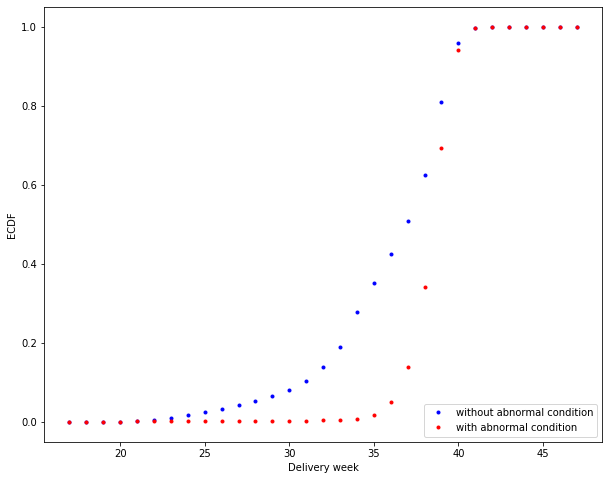

In [102]:

x_a, y_a = ecdf2(a)
x_b, y_b = ecdf2(b)

plt.plot(x_a, y_a, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_b, y_b, marker = '.', linestyle = 'None', color= 'red')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('without abnormal condition', 'with abnormal condition'), loc='lower right')
plt.show()

2. Maternal morbidity

In [104]:
morbid = df[df.no_maternal_morbidity == 0].obstetric_estimate.dropna()
n_morbid = df[df.no_maternal_morbidity == 1].obstetric_estimate.dropna()

a = morbid
b = n_morbid

print('Mean delivery week without maternal morbidity:', round(np.mean(a),2))
print('Mean delivery week with maternal morbidity:', round(np.mean(b),2))

ANOVA_morbid = st.f_oneway(a, b)
print('The F-value for the one-way ANOVA on delivery week with/without maternal morbidity is', round(ANOVA_morbid[0], 2))
print('The p-value for the one-way ANOVA on delivery week with/without maternal morbidity is', round(ANOVA_morbid[1], 4))

Mean delivery week without maternal morbidity: 38.72
Mean delivery week with maternal morbidity: 38.55
The F-value for the one-way ANOVA on delivery week with/without maternal morbidity is 169.82
The p-value for the one-way ANOVA on delivery week with/without maternal morbidity is 0.0


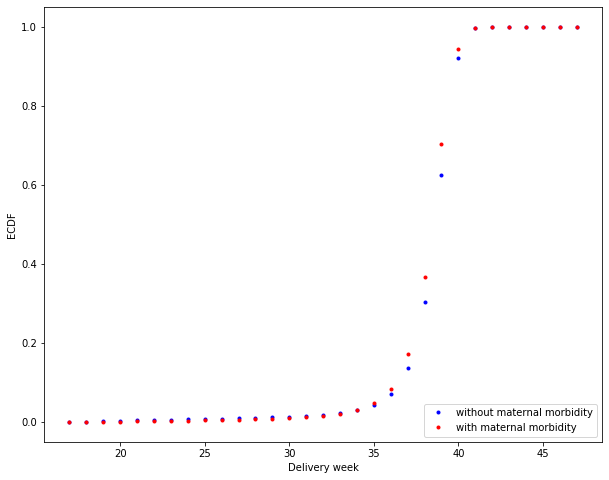

In [106]:

x_a, y_a = ecdf2(a)
x_b, y_b = ecdf2(b)

plt.plot(x_a, y_a, marker = '.', linestyle = 'None', color= 'blue')
plt.plot(x_b, y_b, marker = '.', linestyle = 'None', color= 'red')

_ = plt.xlabel('Delivery week')
_ = plt.ylabel('ECDF')
plt.legend(('without maternal morbidity', 'with maternal morbidity'), loc='lower right')
plt.show()



In [234]:
morbid = df.groupby(('premature', 'no_maternal_morbidity')).no_abnormal_condition.count()
print(morbid)

prop_PM = morbid[1,0]/(morbid[1,0]+morbid[1,1])
prop_FM = morbid[0,0]/(morbid[0,0]+morbid[0,1])

print(prop_PM, prop_FM)

premature  no_maternal_morbidity
False      0.0                        24066
           1.0                      1734949
True       0.0                         1835
           1.0                       157647
Name: no_abnormal_condition, dtype: int64
0.01150600067719241 0.013681520623758183


/Users/berenice/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Interpreting tuple 'by' as a list of keys, rather than a single key. Use 'by=[...]' instead of 'by=(...)'. In the future, a tuple will always mean a single key.
  """Entry point for launching an IPython kernel.


In [23]:
formula = 'obstetric_estimate ~ C(paternity_acknowledged) + C(mother_race) + C(paternity_acknowledged):C(mother_race)'
model = ols(formula, df).fit()
aov_table_1 = anova_lm(model, typ=2)
print(aov_table_1.round(4))

                                                sum_sq         df          F  \
C(paternity_acknowledged)                 4.657971e+04        3.0  3834.0438   
C(mother_race)                            2.554136e+04        5.0  1261.4080   
C(paternity_acknowledged):C(mother_race)  6.575453e+02       15.0    10.8247   
Residual                                  7.762232e+06  1916762.0        NaN   

                                          PR(>F)  
C(paternity_acknowledged)                    0.0  
C(mother_race)                               0.0  
C(paternity_acknowledged):C(mother_race)     0.0  
Residual                                     NaN  


In [24]:
formula = 'obstetric_estimate ~ C(paternity_acknowledged) + C(mother_education) + C(paternity_acknowledged):C(mother_education)'
model = ols(formula, df).fit()
aov_table_2 = anova_lm(model, typ=2)
print(aov_table_2.round(6))

                                                     sum_sq         df  \
C(paternity_acknowledged)                      3.921946e+04        3.0   
C(mother_education)                            2.174621e+04        7.0   
C(paternity_acknowledged):C(mother_education)  1.565581e+03       21.0   
Residual                                       7.547500e+06  1889576.0   

                                                         F  PR(>F)  
C(paternity_acknowledged)                      3272.966930     0.0  
C(mother_education)                             777.762174     0.0  
C(paternity_acknowledged):C(mother_education)    18.664552     0.0  
Residual                                               NaN     NaN  


In [ ]:
plot = df[(df.paternity_acknowledged == 'X') | (df.paternity_acknowledged == 'Y')|(df.paternity_acknowledged == 'N')  ]
plot = plot.groupby(('paternity_acknowledged', 'mother_education')).obstetric_estimate.mean().round(2)
plot = plot.unstack().transpose()
print(plot)


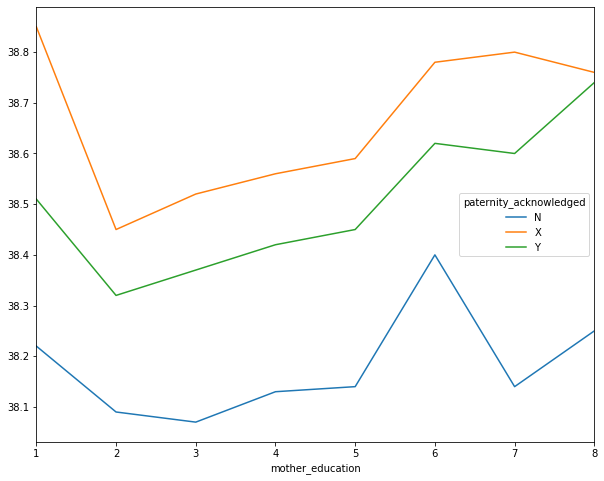

In [232]:
names = ['<8th grade', '8+, no HS degree', 'HS degree', 'Some college', 'AA/AS', 'BA/BS', 'Masters', 'Doctorate']
_ = plot.plot(kind= 'line')
plt.show()

In [140]:

_ = plt.scatter(names, plot.loc[:,0])
#_ = plt.scatter(names, list_fmean)
#_= plt.xticks(rotation=90)
_ = plt.ylabel('Mean Delivery week')
_ = plt.xlabel('Level of education')
#plt.legend(('Mother education', 'Father education'))
plt.show()

KeyError: 0.0

In [36]:
formula = 'obstetric_estimate ~ C(paternity_acknowledged) + mother_age + C(paternity_acknowledged):mother_age'
model = ols(formula, df).fit()
aov_table_3 = anova_lm(model, typ=2)
print(aov_table_3.round(6))

                                            sum_sq         df            F  \
C(paternity_acknowledged)             8.068368e+04        3.0  6630.315807   
mother_age                            5.463476e+03        1.0  1346.910750   
C(paternity_acknowledged):mother_age  2.247240e+03        3.0   184.670659   
Residual                              7.781382e+06  1918344.0          NaN   

                                      PR(>F)  
C(paternity_acknowledged)                0.0  
mother_age                               0.0  
C(paternity_acknowledged):mother_age     0.0  
Residual                                 NaN  


In [48]:
formula = 'obstetric_estimate ~ C(paternity_acknowledged) + prepregnancy_weight + C(paternity_acknowledged):prepregnancy_weight'
model = ols(formula, df).fit()
aov_table_4 = anova_lm(model, typ=2)
print(aov_table_4.round(6))

                                                     sum_sq         df  \
C(paternity_acknowledged)                      6.633288e+04        3.0   
prepregnancy_weight                            6.989845e+03        1.0   
C(paternity_acknowledged):prepregnancy_weight  2.884103e+03        3.0   
Residual                                       7.405460e+06  1876171.0   

                                                         F  PR(>F)  
C(paternity_acknowledged)                      5601.805162     0.0  
prepregnancy_weight                            1770.875156     0.0  
C(paternity_acknowledged):prepregnancy_weight   243.562180     0.0  
Residual                                               NaN     NaN  


In [37]:
formula = 'obstetric_estimate ~ C(paternity_acknowledged) + C(WIC) + C(paternity_acknowledged):C(WIC)'
model = ols(formula, df).fit()
aov_table_3 = anova_lm(model, typ=2)
print(aov_table_3.round(6))

                                        sum_sq         df            F  PR(>F)
C(paternity_acknowledged)         6.297250e+04        3.0  5230.028345     0.0
C(WIC)                            9.368973e+02        1.0   233.435201     0.0
C(paternity_acknowledged):C(WIC)  1.054075e+04        3.0   875.436822     0.0
Residual                          7.610601e+06  1896240.0          NaN     NaN


In [79]:
formula = 'obstetric_estimate ~ C(mother_education) + C(mother_race) + C(mother_education):C(mother_race)'
model = ols(formula, df).fit()
aov_table_1 = anova_lm(model, typ=2)
print(aov_table_1.round(4))

                                          sum_sq         df          F  PR(>F)
C(mother_education)                 4.184277e+04        7.0  1495.2035     0.0
C(mother_race)                      4.108667e+04        5.0  2055.4593     0.0
C(mother_education):C(mother_race)  2.446245e+03       35.0    17.4828     0.0
Residual                            7.563471e+06  1891904.0        NaN     NaN


In [97]:
formula = 'obstetric_estimate ~ C(mother_education) + mother_age + C(mother_education):mother_age'
model = ols(formula, df).fit()
aov_table_5 = anova_lm(model, typ=2)
print(aov_table_5.round(2))

                                    sum_sq         df        F  PR(>F)
C(mother_education)               62573.34        7.0  2227.29     0.0
mother_age                         8137.38        1.0  2027.55     0.0
C(mother_education):mother_age      608.36        7.0    21.65     0.0
Residual                        7598674.16  1893319.0      NaN     NaN


In [98]:
formula = 'obstetric_estimate ~ C(father_race) + C(mother_race) + C(father_race):C(mother_race)'
model = ols(formula, df).fit()
aov_table_1 = anova_lm(model, typ=2)
print(aov_table_1.round(2))

                                     sum_sq         df         F  PR(>F)
C(father_race)                 2.831369e+03        5.0  152.8397     0.0
C(mother_race)                 4.771057e+03        5.0  257.5458     0.0
C(father_race):C(mother_race)  3.648127e+02       25.0    3.9386     0.0
Residual                       5.781005e+06  1560318.0       NaN     NaN


In [99]:
formula = 'obstetric_estimate ~ C(father_education) + C(mother_education) + C(father_education):C(mother_education)'
model = ols(formula, df).fit()
aov_table_1 = anova_lm(model, typ=2)
print(aov_table_1.round(2))

                                             sum_sq         df       F  PR(>F)
C(father_education)                         8363.61        7.0  325.47     0.0
C(mother_education)                         7192.99        7.0  279.91     0.0
C(father_education):C(mother_education)     1574.70       49.0    8.75     0.0
Residual                                 6036132.15  1644252.0     NaN     NaN


In [117]:
formula = 'obstetric_estimate ~ C(no_risk_factors) + visits_week + C(no_risk_factors):visits_week'
model = ols(formula, df).fit()
aov_table_1 = anova_lm(model, typ=2)
print(aov_table_1.round(2))

                                    sum_sq         df         F  PR(>F)
C(no_risk_factors)               161550.77        1.0  41955.15     0.0
visits_week                       52206.04        1.0  13558.04     0.0
C(no_risk_factors):visits_week     1009.77        1.0    262.24     0.0
Residual                        7188484.17  1866868.0       NaN     NaN


In [115]:
df['visits_week'] = df.number_prenatal_visits/(df.obstetric_estimate)



In [113]:
np.mean(df.obstetric_estimate)

38.556701352903794